In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from scipy import stats as st

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import visuals as vs

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

pd.options.display.max_columns = None

## Exploring the Data

In [2]:
data = pd.read_csv("data/prosperLoanData_clean.csv")

The data I've imported above is pre-cleaned, and has been previously explored and summarized.  See https://eskrav.github.io/udacity-data-analyst/explore-and-summarize/explore-and-summarize.html, for a full summary of the cleaning process and a visual exploration of the dataset.  

All currently active loans have already been removed from the dataset, as I am interested only in historical loans whose ultimate fate (repayment or default) is already known.  The few loans which were cancelled have been removed from the data, as they do not result in any gain or yield for the lender, and therefore are not of as much interest to the problem at hand, which is helping lenders deciding where to lend their money.

Several new features have already been added to the original data - for example, simple string and numerical binary factors indicating whether the loan was completed or not; a continuous feature indicating what percent of their investment the lenders in fact earned back on the historical loans; and so forth.  Many of these features I will remove early on in this process, as they are redundant with other features, or of no relevance to the task at hand (e.g., they concern information that principally cannot be available to the lender at the time that they are making their decision).

In total, the dataset contains 55084 data points corresponding to individual loans, with 32 continuous and 23 categorical features.  Although the data has already been cleaned, there is still missing data that was not imputed, and non-normally-distributed continuous features which will need to be transformed.  Continuous features will also need to be scaled.

In [3]:
data.sample(10)

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating.num,ProsperRating.alpha,ProsperScore,ListingCategory.num,BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CurrentlyInGroup,GroupKey,DateCreditPulled,CreditScoreRangeLower,CreditScoreRangeUpper,FirstRecordedCreditLine,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeRange,IncomeVerifiable,StatedMonthlyIncome,LoanKey,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanCurrentDaysDelinquent,LoanFirstDefaultedCycleNumber,LoanMonthsSinceOrigination,LoanNumber,LoanOriginalAmount,LoanOriginationDate,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LP_CustomerPayments,LP_CustomerPrincipalPayments,LP_InterestandFees,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,PercentYield,Completed,Completed.num,CreditScore,CreditHistoryAge
8122,37CE3558560049149E1DCF3,645878,2012-09-26,NaN,36,Chargedoff,2013-08-11,0.35797,0.3177,0.3077,0.2896,0.1625,0.1271,1.0,HR,6.0,6,VA,Skilled Labor,Employed,53.0,True,False,NaN,2012-09-17,640.0,659.0,1963-07-01,3.0,3.0,21.0,1,0.0,1.0,1.0,9.0,15184.0,6.0,1.0,0.0,1251.0,0.19,5109.0,12.0,0.55,0.0,0.08,"$50,000-74,999",True,4333.333333,9FAC36627950590103CEC58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,333,10.0,17,75741,3500,2012-10-11,Q4 2012,852F35578173098828EA0EF,151.99,759.95,315.46,444.49,-13.99,0.0000,3184.54,3184.54,0.00,1.0,0,0,0.0,15,HR,-0.786869,Not Completed,0,649.5,49.273973
46236,5B173468316754142DC7284,435264,2009-11-24,NaN,36,Completed,2012-12-01,0.12511,0.1040,0.0940,0.0727,0.0210,0.0727,6.0,A,9.0,1,TN,Teacher,Full-time,51.0,True,False,NaN,2009-11-05,740.0,759.0,1988-09-01,6.0,4.0,24.0,3,372.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,17009.0,0.62,10344.0,21.0,0.90,1.0,0.13,"$50,000-74,999",True,4166.666667,B99D357247498687973E590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,51,39731,5500,2009-12-01,Q4 2009,80F53464914928610B3875C,178.50,6426.22,5500.00,926.22,-89.05,0.0000,0.00,0.00,0.00,1.0,0,0,0.0,171,A,0.152213,Completed,1,749.5,21.243836
54388,D761338306812656389AA99,108832,2007-03-09,C,36,Defaulted,2007-09-13,0.16194,0.1500,0.1400,NaN,NaN,NaN,NaN,NaN,NaN,0,NY,Other,Self-employed,10.0,True,False,NaN,2007-03-01,640.0,659.0,1993-06-04,8.0,6.0,17.0,6,394.0,6.0,8.0,0.0,0.0,1.0,0.0,0.0,5477.0,0.42,7523.0,15.0,0.86,3.0,0.17,"$25,000-49,999",True,3333.333333,48153383981665504ACCFCD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,223,6.0,84,8569,1500,2007-03-15,Q1 2007,940033822795455237D26C4,52.00,37.00,11.11,25.89,-1.73,0.0000,1488.89,1488.89,0.00,1.0,0,0,0.0,24,C,-0.976487,Not Completed,0,649.5,13.769863
29062,0A6C339288470911282CE65,151857,2007-06-13,C,36,Completed,2010-07-14,0.19178,0.1845,0.1645,NaN,NaN,NaN,NaN,NaN,NaN,0,CA,Clerical,Full-time,3.0,False,True,0F82338819107915829B421,2007-05-29,640.0,659.0,1989-03-01,14.0,13.0,25.0,14,499.0,0.0,9.0,0.0,0.0,1.0,0.0,0.0,14378.0,0.42,18658.0,25.0,0.88,0.0,0.62,"$25,000-49,999",True,3000.000000,77CD3392486168225C918EE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,80,16558,10000,2007-07-02,Q3 2007,26DA3390275516670CF8775,363.79,12940.55,10000.01,2940.54,-168.50,0.0000,0.00,0.00,0.00,1.0,0,1,50.0,253,C,0.277204,Completed,1,649.5,18.295890
8165,001D33654297803968707DD,23976,2006-07-10,E,36,Defaulted,2007

Based on my previous exploration of this data, I am immediately removing those features which are irrelevant to the task at hand, or redundant with other features:

The following are internal loan and borrower identifiers, which are redundant with other identifiers, and are of no independent use: `ListingKey`, `ListingNumber`, `LoanKey`, `LoanNumber`, `MemberKey`.

The following concern internal group membership, about which there is no further information available (furthermore, most loans do not belong to groups); I will therefore leave these aside for the time being: `CurrentlyInGroup`, `GroupKey`.

The following concern information that is not yet available to the lender at the time they are making the decision of whether to lend money, and therefore cannot serve as a useful feature for the lender, or is not directly informative about whether the loan is closed, or not: `ClosedDate`, `LP_CustomerPayments`, `LP_CustomerPrincipalPayments`, `LP_InterestandFees`, `LP_ServiceFees`, `LP_CollectionFees`, `LP_GrossPrincipalLoss`, `LP_NetPrincipalLoss`, `LP_NonPrincipalRecoverypayments`, `LoanCurrentDaysDelinquent`, `LoanFirstDefaultedCycleNumber`, `LoanMonthsSinceOrigination`, `PercentYield`.

The following are redundant with the `Rating` feature, which combines pre- and post-2009 Prosper rating schemes, as described in the previous data summary: `ProsperRating.num`, `ProsperRating.alpha`, `CreditGrade`.

The following are redundant with the label of interest (`Completed.num`), which indicates whether the loan was repaid in full, or defaulted: `LoanStatus`, `Completed`.  The following are redundant with `CreditScore`, which imputes a single average expected credit score (with minor loss of information): `CreditScoreRangeLower`, `CreditScoreRangeUpper`.  The following is redundant with the loan origination date: `LoanOriginationQuarter`.  The following is redundant with the borrower rate: `BorrowerAPR`.  The following is redundant with monthly income, which as a continuous feature is more easily interpretable: `IncomeRange`.  The following is redundant with age of credit history at the time the loan was originated: `FirstRecordedCreditLine`.

Almost all loans are completely funded (`PercentFunded`).

In [4]:
redundant_irrelevant = ["ListingKey", "ListingNumber", "LoanKey", "LoanNumber", "LoanStatus", "ClosedDate",
                       "ProsperRating.num", "ProsperRating.alpha", "CreditScoreRangeLower", "CreditScoreRangeUpper",
                       "LoanOriginationQuarter", "MemberKey", "LP_CustomerPayments", "LP_CustomerPrincipalPayments",
                       "LP_InterestandFees", "LP_ServiceFees", "LP_CollectionFees", "LP_GrossPrincipalLoss",
                       "LP_NetPrincipalLoss", "LP_NonPrincipalRecoverypayments", "PercentFunded", "PercentYield",
                       "Completed", "LoanCurrentDaysDelinquent", "LoanFirstDefaultedCycleNumber", 
                       "LoanMonthsSinceOrigination", "BorrowerAPR", "CurrentlyInGroup", "GroupKey", "IncomeRange",
                       "CreditGrade", "FirstRecordedCreditLine"]

data.drop(redundant_irrelevant, axis=1, inplace=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55084 entries, 0 to 55083
Data columns (total 55 columns):
ListingCreationDate                    55084 non-null object
Term                                   55084 non-null int64
BorrowerRate                           55084 non-null float64
LenderYield                            55084 non-null float64
EstimatedEffectiveYield                26005 non-null float64
EstimatedLoss                          26005 non-null float64
EstimatedReturn                        26005 non-null float64
ProsperScore                           26005 non-null float64
ListingCategory.num                    55084 non-null int64
BorrowerState                          49572 non-null object
Occupation                             52819 non-null object
EmploymentStatus                       52832 non-null object
EmploymentStatusDuration               47473 non-null float64
IsBorrowerHomeowner                    55084 non-null bool
DateCreditPulled                  

First, I convert the dates to continuous timestamps, as the methods I use are not able to handle datetime objects:

In [6]:
data['ListingCreationDate'] = pd.to_datetime(data['ListingCreationDate']).astype(np.int64)
data['DateCreditPulled'] = pd.to_datetime(data['DateCreditPulled']).astype(np.int64)
data['LoanOriginationDate'] = pd.to_datetime(data['LoanOriginationDate']).astype(np.int64)

Below, I examine features with null values, and infer from existing values if they can/should be imputed (e.g., an `NA` may represent a 0 for some features, if 0's are not generally coded, but would be expected to show up naturally):

In [7]:
data_num_missing = data.isna().sum()
data_num_missing

ListingCreationDate                        0
Term                                       0
BorrowerRate                               0
LenderYield                                0
EstimatedEffectiveYield                29079
EstimatedLoss                          29079
EstimatedReturn                        29079
ProsperScore                           29079
ListingCategory.num                        0
BorrowerState                           5512
Occupation                              2265
EmploymentStatus                        2252
EmploymentStatusDuration                7611
IsBorrowerHomeowner                        0
DateCreditPulled                           0
CurrentCreditLines                      7600
OpenCreditLines                         7600
TotalCreditLinespast7years               696
OpenRevolvingAccounts                      0
OpenRevolvingMonthlyPayment                0
InquiriesLast6Months                     696
TotalInquiries                          1155
CurrentDel

In [8]:
# percent of data missing per category:
data.isna().mean().round(4) * 100

ListingCreationDate                     0.00
Term                                    0.00
BorrowerRate                            0.00
LenderYield                             0.00
EstimatedEffectiveYield                52.79
EstimatedLoss                          52.79
EstimatedReturn                        52.79
ProsperScore                           52.79
ListingCategory.num                     0.00
BorrowerState                          10.01
Occupation                              4.11
EmploymentStatus                        4.09
EmploymentStatusDuration               13.82
IsBorrowerHomeowner                     0.00
DateCreditPulled                        0.00
CurrentCreditLines                     13.80
OpenCreditLines                        13.80
TotalCreditLinespast7years              1.26
OpenRevolvingAccounts                   0.00
OpenRevolvingMonthlyPayment             0.00
InquiriesLast6Months                    1.26
TotalInquiries                          2.10
CurrentDel

In [9]:
# value counts for feature of choice
data.TradesOpenedLast6Months.value_counts()

0.0     23139
1.0     13692
2.0      6265
3.0      2540
4.0      1055
5.0       440
6.0       220
7.0        87
8.0        41
9.0        21
11.0       12
10.0       12
12.0        8
13.0        5
14.0        2
17.0        2
15.0        2
20.0        1
Name: TradesOpenedLast6Months, dtype: int64

In [10]:
data.describe()

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatusDuration,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Completed.num,CreditScore,CreditHistoryAge
count,5.508400e+04,55084.000000,55084.000000,55084.000000,26005.000000,26005.000000,26005.000000,26005.000000,55084.000000,47473.000000,5.508400e+04,47484.000000,47484.000000,54388.000000,55084.000000,55084.000000,54388.000000,53929.000000,54388.000000,47466.000000,54097.000000,54388.000000,47484.000000,4.748400e+04,47484.000000,47544.000000,47544.000000,47544.000000,47544.000000,50854.000000,55084.000000,10539.000000,10539.000000,10539.000000,10539.000000,10539.000000,10539.000000,10539.000000,10442.000000,55084.000000,5.508400e+04,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,54494.000000,54388.000000
mean,1.247579e+18,36.942851,0.200423,0.190292,0.176231,0.093795,0.107539,6.265987,2.407578,80.895878,1.247556e+18,9.568634,8.337861,25.276164,6.078389,325.307403,2.051850,7.166608,0.906229,1050.814962,4.571658,0.331029,0.023713,1.568936e+04,0.530446,10844.170411,21.786808,0.856399,0.909326,0.289866,5054.723018,1.332764,20.078850,19.486099,0.544074,0.048202,7104.678315,2332.674796,1.146811,6261.892746,1.248817e+18,223.729882,0.089391,0.046111,33.589037,104.897665,0.691199,681.246247,14.670098
std,6.899523e+16,7.333480,0.081291,0.080726,0.081519,0.055062,0.038377,2.319612,3.397823,84.669661,6.921332e+16,5.582143,4.985417,14.268205,4.528996,448.839320,3.147988,8.214843,2.595972,6676.861621,10.689471,0.790619,0.180400,3.401072e+04,0.350780,21869.026283,12.456163,0.174057,1.240458,0.736738,5711.051112,0.676027,15.871918,15.466862,2.151244,0.509123,6395.297342,3285.130455,50.913387,5217.758039,6.904301e+16,185.727523,0.453767,0.327691,422.191018,108.893346,0.462003,81.908137,7.554535
min,1.131494e+18,12.000000,0.000000,-0.010000,-0.182700,0.004900,-0.182700,1.000000,0.000000,0.000000,1.131494e+18,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-194.000000,1000.000000,1.132013e+18,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,9.500000,0.019178
25%,1.186963e+18,36.000000,0.135000,0.125000,0.110600,0.052000,0.078000,5.000000,0.000000,21.000000,1.186358e+18,6.000000,5.000000,15.000000,3.000000,60.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.614000e+03,0.210000,506.000000,13.000000,0.770000,0.000000,0.130000,2810.604167,1.000000,9.000000,9.000000,0.000000,0.000000,3000.000000,0.000000,-32.000000,2600.000000,1.187914e+18,98.290000,0.000000,0.000000,0.000000,31.000000,0.000000,649.500000,9.416438
50%,1.219277e+18,36.000000,0.194500,0.182550,0.171500,0.098000,0.114400,6.000000,1.000000,52.000000,1.219190e+18,9.000000,8.000000,23.000000,5.000000,183.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.073000e+03,0.560000,3245.500000,20.000000,0.920000,1.000000,0.200000,4166.666667,1.000000,15.000000,14.000000,0.000000,0.000000,5000.000000,1098.020000,0.000000,4500.000000,1.220

### Data Imputation

`EstimatedEffectiveYield` was a measure not available prior to mid-2009.  However, it measures the borrower rate minus expected fees, which can be imputed.  Given the data is not normally distributed (which will be examined further below), I will impute missing data with the median difference between borrower rate and estimated effective yield, as implemented in https://www.kaggle.com/jschnessl/prosper-analysis/notebook:

In [11]:
data[data.EstimatedEffectiveYield.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
9469,1175472000000000000,36,0.1425,0.1325,NaN,NaN,NaN,NaN,0,OK,Computer Programmer,Full-time,91.0,False,1175385600000000000,8.0,8.0,11.0,6,440.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,12827.0,0.79,2502.0,11.0,1.00,0.0,0.25000,True,3505.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1176249600000000000,68.60,0,0,0.0,81,D,1,629.5,8.304110
31244,1162339200000000000,36,0.2500,0.2450,NaN,NaN,NaN,NaN,0,TX,Clerical,Not available,NaN,True,1162339200000000000,NaN,NaN,30.0,6,175.0,6.0,26.0,5.0,NaN,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.79000,True,1600.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1162944000000000000,119.28,0,0,0.0,24,D,0,609.5,11.389041
32539,1149984000000000000,36,0.2475,0.2425,NaN,NaN,NaN,NaN,0,WA,NaN,NaN,NaN,True,1149379200000000000,NaN,NaN,22.0,2,60.0,4.0,8.0,5.0,NaN,12.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.12000,True,4166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1150675200000000000,39.63,0,0,0.0,10,HR,0,489.5,8.539726
50507,1143158400000000000,36,0.1500,0.1450,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,False,1143158400000000000,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.08466,True,5516.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3001,1143676800000000000,101.70,0,0,0.0,33,C,1,NaN,NaN
12625,1191024000000000000,36,0.2699,0.2599,NaN,NaN,NaN,NaN,0,MO,Analyst,Full-time,80.0,True,1191024000000000000,12.0,9.0,69.0,6,272.0,18.0,35.0,1.0,12420.0,24.0,1.0,0.0,8494.0,0.84,1483.0,62.0,0.85,4.0,0.24000,True,4333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1191888000000000000,204.10,0,0,0.0,55,D,0,629.5,14.002740


In [12]:
estimated_fees = (data["BorrowerRate"] - data["EstimatedEffectiveYield"]).median()
data["EstimatedEffectiveYield"].fillna(data["BorrowerRate"] - estimated_fees, inplace=True)
data["EstimatedEffectiveYield"].isnull().sum()

0

It's unclear how `EstimatedLoss` is computed.  Given the potential importance of this feature, and the difficulty in imputing it -- as well as the clear dependance on other features, such as risk measures -- I will not attempt to impute this feature, and will look for an algorithm robust to missing values, or simply leave this feature out.  The other potential solution would be to analyze pre-mid-2009 and post-mid-2009 datasets separately.  Ideally, one may want to do linear regression to infer likely values, but that is currently beyond the scope of this project.

In [13]:
data[data.EstimatedLoss.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
40622,1180310400000000000,36,0.1250,0.1150,0.1014,NaN,NaN,NaN,0,OH,Other,Full-time,3.0,True,1180310400000000000,8.0,7.0,28.0,5,122.0,2.0,9.0,2.0,1180.0,2.0,0.0,0.0,7794.0,0.83,1550.0,25.0,0.74,0.0,0.09,True,2600.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1181606400000000000,100.36,0,0,0.0,97,C,0,669.5,12.408219
52248,1215388800000000000,36,0.3500,0.3400,0.3264,NaN,NaN,NaN,1,NJ,Professional,Full-time,43.0,True,1214352000000000000,13.0,11.0,20.0,9,2574.0,2.0,12.0,0.0,0.0,0.0,0.0,0.0,90923.0,0.87,13407.0,18.0,0.94,1.0,0.63,True,4958.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1215993600000000000,90.47,0,0,0.0,31,E,0,589.5,18.364384
7546,1152230400000000000,36,0.2875,0.2825,0.2639,NaN,NaN,NaN,0,TX,NaN,NaN,NaN,True,1150761600000000000,NaN,NaN,58.0,11,224.0,6.0,27.0,11.0,NaN,17.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.47,True,2988.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1153440000000000000,125.31,0,0,0.0,30,E,0,589.5,7.471233
13537,1182211200000000000,36,0.2695,0.2495,0.2459,NaN,NaN,NaN,0,AL,Other,Self-employed,20.0,False,1181347200000000000,12.0,8.0,47.0,8,59.0,2.0,7.0,2.0,0.0,11.0,0.0,0.0,3333.0,0.97,89.0,44.0,0.90,4.0,0.79,True,1000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4000,1183420800000000000,163.19,1,1,200.0,52,E,1,569.5,14.890411
20523,1169424000000000000,36,0.1800,0.1650,0.1564,NaN,NaN,NaN,0,NaN,Laborer,Not available,NaN,False,1168905600000000000,NaN,NaN,9.0,3,92.0,0.0,2.0,1.0,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.19,True,1666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6200,1170633600000000000,224.14,0,0,0.0,99,D,0,629.5,4.920548


`EstimatedReturn` is the difference between estimated yield and estimated loss, and cannot be computed without the latter.  I will treat this feature similarly to `EstimatedLoss`.

In [14]:
data[data.EstimatedReturn.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
5546,1220054400000000000,36,0.145,0.135,0.1214,NaN,NaN,NaN,3,TX,Other,Self-employed,27.0,False,1219017600000000000,9.0,7.0,13.0,3,72.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,3791.0,0.37,6209.0,10.0,0.83,1.0,NaN,False,2166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1220918400000000000,103.26,0,0,0.0,140,B,1,709.5,10.912329
52570,1166400000000000000,36,0.290,0.285,0.2664,NaN,NaN,NaN,0,CA,Executive,Not available,NaN,False,1165968000000000000,NaN,NaN,16.0,0,0.0,5.0,13.0,11.0,NaN,38.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,True,3750.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2550,1166745600000000000,106.86,0,0,0.0,27,HR,0,489.5,5.383562
51561,1165968000000000000,36,0.226,0.221,0.2024,NaN,NaN,NaN,0,NaN,Tradesman - Mechanic,Not available,NaN,False,1165968000000000000,NaN,NaN,9.0,2,37.0,1.0,4.0,1.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.18,True,2000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500,1166572800000000000,57.75,0,0,0.0,9,D,1,629.5,2.805479
12158,1166486400000000000,36,0.240,0.225,0.2164,NaN,NaN,NaN,0,MI,Sales - Commission,Not available,NaN,False,1165795200000000000,NaN,NaN,24.0,1,0.0,7.0,23.0,11.0,NaN,9.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,True,5496.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1782,1167350400000000000,69.91,0,0,0.0,21,HR,0,529.5,12.043836
21757,1176595200000000000,36,0.105,0.095,0.0814,NaN,NaN,NaN,0,NaN,Student - College Senior,Full-time,44.0,False,1175817600000000000,3.0,2.0,25.0,2,84.0,2.0,4.0,1.0,1132.0,0.0,0.0,0.0,2026.0,1.01,0.0,3.0,0.50,2.0,NaN,False,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1975,1177027200000000000,64.19,0,0,0.0,1,HR,1,549.5,10.605479


`ProsperScore` is a post-2009 measure.  In my exploratory analysis, it seemed that it might not be entirely redundant with the various Prosper ratings.  I don't believe there is any good way to impute this feature, and will either omit it from the model, or use a model robust to missing values.

In [15]:
data[data.ProsperScore.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
7131,1155600000000000000,36,0.1700,0.1650,0.1464,NaN,NaN,NaN,0,WV,Other,Not available,NaN,False,1154131200000000000,NaN,NaN,2.0,0,0.0,0.0,1.0,0.0,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13,True,916.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1600,1156118400000000000,57.04,0,0,0.0,14,NC,0,9.5,21.306849
24254,1171324800000000000,36,0.0900,0.0850,0.0664,NaN,NaN,NaN,0,NJ,Construction,Full-time,0.0,True,1171324800000000000,7.0,7.0,15.0,7,464.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,10142.0,0.29,24523.0,15.0,0.93,2.0,0.21,True,4083.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500,1172102400000000000,47.70,0,0,0.0,25,A,1,749.5,14.545205
16225,1199491200000000000,36,0.1692,0.1592,0.1456,NaN,NaN,NaN,4,MI,Administrative Assistant,Full-time,78.0,False,1198886400000000000,22.0,18.0,41.0,17,836.0,2.0,5.0,1.0,694.0,12.0,1.0,0.0,27207.0,0.97,523.0,37.0,0.78,1.0,0.37,True,3779.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1200441600000000000,35.61,0,0,0.0,42,C,1,649.5,31.449315
18487,1178409600000000000,36,0.2900,0.2600,0.2664,NaN,NaN,NaN,0,NC,Sales - Commission,Full-time,13.0,False,1177632000000000000,30.0,29.0,39.0,27,580.0,21.0,63.0,0.0,0.0,0.0,1.0,0.0,14291.0,0.89,1640.0,38.0,0.94,4.0,0.62,True,2782.583333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5800,1179273600000000000,243.05,0,0,0.0,32,HR,0,529.5,23.610959
9185,1219104000000000000,36,0.2695,0.2595,0.2459,NaN,NaN,NaN,7,UT,Professional,Full-time,418.0,False,1218672000000000000,9.0,8.0,23.0,5,296.0,2.0,4.0,1.0,1382.0,16.0,0.0,0.0,36428.0,0.80,8803.0,21.0,0.76,2.0,0.20,True,4589.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1219968000000000000,54.55,0,0,0.0,26,C,1,649.5,31.071233


`BorrowerState` cannot be imputed.  Unknown values can be labeled as such; however, given the number of feature levels, and no clear expectations for how this feature will affect reliability, the states may need to be grouped into more meaningful geographical regions or categories prior to use.  I leave this for future work.

In [16]:
data[data.BorrowerState.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
8530,1166486400000000000,36,0.150,0.135,0.1264,NaN,NaN,NaN,0,NaN,Tradesman - Mechanic,Not available,NaN,False,1165795200000000000,NaN,NaN,13.0,7,331.0,1.0,9.0,2.0,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.32000,True,2500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500,1167177600000000000,52.00,0,0,0.0,5,E,1,589.5,4.030137
39097,1141257600000000000,36,0.070,0.065,0.0464,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,False,1141257600000000000,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03698,True,5416.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6001,1142553600000000000,183.22,0,0,0.0,50,AA,1,NaN,NaN
41050,1182988800000000000,36,0.100,0.095,0.0764,NaN,NaN,NaN,0,NaN,Attorney,Full-time,0.0,False,1182902400000000000,13.0,8.0,35.0,7,122.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,4856.0,0.25,11319.0,18.0,0.94,4.0,NaN,False,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1183680000000000000,161.34,0,0,0.0,142,A,1,729.5,6.578082
13199,1165795200000000000,36,0.290,0.275,0.2664,NaN,NaN,NaN,0,NaN,Tradesman - Mechanic,Not available,NaN,True,1164153600000000000,NaN,NaN,21.0,1,20.0,5.0,24.0,12.0,NaN,7.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.40000,True,2566.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1166400000000000000,125.72,0,0,0.0,41,E,0,549.5,8.200000
15252,1177200000000000000,36,0.145,0.135,0.1214,NaN,NaN,NaN,0,NaN,Other,Full-time,1.0,False,1177027200000000000,5.0,5.0,6.0,4,122.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,3244.0,0.75,1056.0,6.0,1.00,1.0,0.16000,True,2083.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1177977600000000000,172.10,0,0,0.0,123,C,0,669.5,2.550685


In [17]:
data.drop(columns="BorrowerState", axis=1, inplace=True)

`Occupation` cannot be imputed.  Unknown values can be labeled as such, but as with state, known values would need to be grouped meaningfully (e.g. by working class, minimally) to be informative.  I likewise leave this for future work, and for now drop this feature from the dataset.

In [18]:
data[data.Occupation.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
42029,1151366400000000000,36,0.2000,0.1950,0.1764,NaN,NaN,NaN,0,NaN,NaN,NaN,False,1150070400000000000,NaN,NaN,11.0,5,123.0,1.0,7.0,2.0,NaN,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.08000,True,2250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1400,1152144000000000000,20.27,0,0,0.0,1,HR,1,509.5,9.197260
27825,1147478400000000000,36,0.2300,0.2250,0.2064,NaN,NaN,NaN,0,NaN,NaN,NaN,True,1146873600000000000,NaN,NaN,47.0,0,0.0,3.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03000,True,8583.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1148428800000000000,77.42,0,0,0.0,26,HR,1,529.5,14.410959
52608,1149552000000000000,36,0.2500,0.2450,0.2264,NaN,NaN,NaN,0,NaN,NaN,NaN,False,1149033600000000000,NaN,NaN,7.0,1,0.0,2.0,8.0,2.0,NaN,18.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.14000,True,2461.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1391,1149724800000000000,54.25,0,0,0.0,13,E,1,589.5,9.665753
48422,1143244800000000000,36,0.3575,0.3525,0.3339,NaN,NaN,NaN,0,NaN,NaN,NaN,False,1143158400000000000,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.18235,True,1444.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1144713600000000000,228.31,0,0,0.0,45,HR,0,NaN,NaN
12200,1143072000000000000,36,0.1500,0.1450,0.1264,NaN,NaN,NaN,0,NaN,NaN,NaN,False,1142899200000000000,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.11392,True,666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2700,1143763200000000000,93.60,0,0,0.0,77,E,1,NaN,NaN


In [19]:
data.drop(columns="Occupation", axis=1, inplace=True)

`EmploymentStatus` cannot be imputed.  Unknown values will be labeled as such.

In [20]:
data[data.EmploymentStatus.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
283,1147910400000000000,36,0.2350,0.2300,0.2114,NaN,NaN,NaN,0,NaN,NaN,True,1147910400000000000,NaN,NaN,23.0,0,0.0,3.0,NaN,2.0,NaN,13.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10000,True,3666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3500,1148342400000000000,136.40,0,0,0.0,35,C,0,669.5,16.263014
25093,1148256000000000000,36,0.2375,0.2325,0.2139,NaN,NaN,NaN,0,NaN,NaN,True,1148256000000000000,NaN,NaN,41.0,0,0.0,1.0,NaN,4.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.26000,True,3000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1149120000000000000,117.31,0,0,0.0,33,E,0,569.5,19.441096
22243,1146441600000000000,36,0.2375,0.2325,0.2139,NaN,NaN,NaN,0,NaN,NaN,False,1146441600000000000,NaN,NaN,16.0,0,0.0,3.0,NaN,6.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01544,True,4333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1200,1146787200000000000,23.74,0,0,0.0,7,HR,1,469.5,8.838356
17552,1151884800000000000,36,0.1175,0.1125,0.0939,NaN,NaN,NaN,0,NaN,NaN,False,1151884800000000000,NaN,NaN,6.0,0,0.0,0.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.16000,True,866.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2500,1153180800000000000,81.55,0,0,0.0,31,C,1,649.5,4.660274
43129,1147737600000000000,36,0.1550,0.1350,0.1314,NaN,NaN,NaN,0,NaN,NaN,True,1147651200000000000,NaN,NaN,31.0,0,0.0,8.0,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.15000,True,5759.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4500,1149033600000000000,157.10,0,0,0.0,50,C,1,649.5,26.893151


In [21]:
data["EmploymentStatus"].fillna("Unknown", inplace=True)
data["EmploymentStatus"].isnull().sum()

0

I will impute `EmploymentStatusDuration` with the median value for this variable.  I would also consider dropping all missing rows, potentially, expecially if there were also missing values in other difficult-to-impute features.  Another possibility, to be explored in the future, is using linear regression to impute these values based on features judged likely to be relevant (e.g., income, occupation, home ownership).

In [22]:
data[data.EmploymentStatusDuration.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
39028,1160438400000000000,36,0.0999,0.0949,0.0763,NaN,NaN,NaN,0,Not available,NaN,True,1160438400000000000,NaN,NaN,32.0,9,115.0,4.0,13.0,0.0,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.14000,True,7500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000,1161907200000000000,322.62,0,0,0.0,296,A,0,729.5,23.704110
15565,1158019200000000000,36,0.2000,0.1825,0.1764,NaN,NaN,NaN,0,Not available,NaN,False,1156982400000000000,NaN,NaN,9.0,0,0.0,3.0,5.0,2.0,NaN,8.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.16000,True,2333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2500,1158883200000000000,92.91,0,0,0.0,25,HR,1,509.5,4.008219
3343,1154649600000000000,36,0.1288,0.1238,0.1052,NaN,NaN,NaN,0,Not available,NaN,True,1154476800000000000,NaN,NaN,26.0,3,150.0,7.0,16.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.20000,True,5833.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2300,1155168000000000000,77.36,0,0,0.0,59,C,1,649.5,8.339726
33636,1144022400000000000,36,0.1900,0.1850,0.1664,NaN,NaN,NaN,0,Unknown,NaN,False,1144022400000000000,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.16516,True,2250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4000,1144800000000000000,146.62,0,0,0.0,39,D,1,NaN,NaN
22796,1170633600000000000,36,0.2400,0.2350,0.2164,NaN,NaN,NaN,0,Not available,NaN,False,1169683200000000000,NaN,NaN,18.0,1,0.0,32.0,42.0,8.0,NaN,73.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.22000,True,2881.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1171929600000000000,39.23,0,0,0.0,16,HR,0,509.5,8.230137


In [23]:
median_employment_status_duration = data["EmploymentStatusDuration"].median()
data["EmploymentStatusDuration"].fillna(median_employment_status_duration, inplace=True)
data["EmploymentStatusDuration"].isnull().sum()

0

It's unclear what the right course of action here is, but I will impute missing `CurrentCreditLines` with median values.

In [24]:
data[data.CurrentCreditLines.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
8223,1162598400000000000,36,0.2000,0.1900,0.1764,NaN,NaN,NaN,0,Not available,52.0,True,1161302400000000000,NaN,NaN,19.0,0,0.0,0.0,2.0,2.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07000,True,2629.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1162944000000000000,185.82,0,0,0.0,55,B,0,689.5,17.030137
19346,1158105600000000000,36,0.1900,0.1850,0.1664,NaN,NaN,NaN,0,Not available,52.0,True,1158105600000000000,NaN,NaN,30.0,6,96.0,2.0,3.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.14000,True,11666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20000,1159142400000000000,733.12,0,0,0.0,190,B,1,709.5,13.594521
52268,1141689600000000000,36,0.2200,0.2075,0.1964,NaN,NaN,NaN,0,Unknown,52.0,False,1140912000000000000,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.29079,True,6666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1142294400000000000,114.57,0,0,0.0,26,D,0,NaN,NaN
4143,1154649600000000000,36,0.1425,0.1375,0.1189,NaN,NaN,NaN,0,Not available,52.0,True,1154649600000000000,NaN,NaN,41.0,3,420.0,7.0,13.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.29000,True,8000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000,1155600000000000000,342.99,0,0,0.0,43,A,0,749.5,17.115068
36946,1168560000000000000,36,0.1500,0.1400,0.1264,NaN,NaN,NaN,0,Unknown,52.0,False,1168387200000000000,NaN,NaN,42.0,6,56.0,9.0,22.0,1.0,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.14000,True,6250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1800,1169424000000000000,0.00,0,0,0.0,24,D,1,629.5,15.712329


In [25]:
median_credit_lines = data["CurrentCreditLines"].median()
data["CurrentCreditLines"].fillna(median_credit_lines, inplace=True)
data["CurrentCreditLines"].isnull().sum()

0

Same for `OpenCreditLines`.

In [26]:
data[data.OpenCreditLines.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
13236,1146009600000000000,36,0.2075,0.2025,0.1839,NaN,NaN,NaN,0,Unknown,52.0,False,1146009600000000000,9.0,NaN,56.0,0,0.0,5.0,NaN,1.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09835,True,2500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2500,1146528000000000000,93.87,0,0,0.0,25,D,1,609.5,20.698630
26225,1154995200000000000,36,0.0969,0.0894,0.0733,NaN,NaN,NaN,0,Unknown,52.0,True,1154995200000000000,9.0,NaN,12.0,6,366.0,1.0,2.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.16000,True,4166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000,1156464000000000000,321.22,0,0,0.0,204,AA,1,769.5,5.421918
44293,1161820800000000000,36,0.1280,0.1130,0.1044,NaN,NaN,NaN,0,Not available,52.0,True,1161820800000000000,9.0,NaN,20.0,5,982.0,2.0,3.0,0.0,NaN,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.17000,True,7800.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14000,1163721600000000000,426.45,0,0,0.0,347,B,1,689.5,12.263014
15710,1170806400000000000,36,0.1310,0.1110,0.1074,NaN,NaN,NaN,0,Not available,52.0,True,1170806400000000000,9.0,NaN,14.0,2,262.0,0.0,6.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.42000,True,2250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1171929600000000000,168.71,0,0,0.0,144,B,1,709.5,17.495890
26498,1164758400000000000,36,0.1500,0.1350,0.1264,NaN,NaN,NaN,0,Not available,52.0,False,1164758400000000000,9.0,NaN,4.0,1,20.0,4.0,7.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.05000,True,2083.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2500,1165276800000000000,86.66,0,0,0.0,32,D,0,609.5,3.838356


In [27]:
median_open_credit_lines = data["OpenCreditLines"].median()
data["OpenCreditLines"].fillna(median_open_credit_lines, inplace=True)
data["OpenCreditLines"].isnull().sum()

0

Same for `TotalCreditLinespast7years`.

In [28]:
data[data.TotalCreditLinespast7years.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
3546,1143072000000000000,36,0.2000,0.1825,0.1764,NaN,NaN,NaN,0,Unknown,52.0,False,1142380800000000000,9.0,8.0,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07570,True,3500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2555,1144108800000000000,94.95,0,0,0.0,19,E,1,NaN,NaN
16283,1144886400000000000,36,0.2000,0.1825,0.1764,NaN,NaN,NaN,0,Unknown,52.0,False,1143417600000000000,9.0,8.0,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07149,True,2426.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1145836800000000000,111.49,0,0,0.0,87,E,0,NaN,NaN
37466,1140825600000000000,36,0.2200,0.2150,0.1964,NaN,NaN,NaN,0,Unknown,52.0,False,1140652800000000000,9.0,8.0,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02330,True,4916.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1141776000000000000,114.57,0,0,0.0,22,HR,0,NaN,NaN
51152,1140825600000000000,36,0.0875,0.0825,0.0639,NaN,NaN,NaN,0,Unknown,52.0,False,1140825600000000000,9.0,8.0,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.19893,True,8200.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12000,1141689600000000000,375.06,0,0,0.0,55,A,1,NaN,NaN
8985,1144368000000000000,36,0.1750,0.1700,0.1514,NaN,NaN,NaN,0,Unknown,52.0,False,1144195200000000000,9.0,8.0,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.31708,True,4333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000,1145232000000000000,359.02,0,0,0.0,49,B,1,NaN,NaN


In [29]:
median_7_credit_lines = data["TotalCreditLinespast7years"].median()
data["TotalCreditLinespast7years"].fillna(median_7_credit_lines, inplace=True)
data["TotalCreditLinespast7years"].isnull().sum()

0

I will impute missing values in `InquiriesLast6Months` with median values.

In [30]:
data[data.InquiriesLast6Months.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
52969,1163376000000000000,36,0.20,0.195,0.1764,NaN,NaN,NaN,0,Not available,52.0,False,1162252800000000000,9.0,8.0,23.0,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1708.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1200,1164844800000000000,44.60,0,0,0.0,4,NC,0,9.5,NaN
15403,1141689600000000000,36,0.09,0.085,0.0664,NaN,NaN,NaN,0,Unknown,52.0,False,1141689600000000000,9.0,8.0,23.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.14363,True,760.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1200,1141862400000000000,38.16,0,0,0.0,8,B,1,NaN,NaN
21529,1143936000000000000,36,0.18,0.175,0.1564,NaN,NaN,NaN,0,Unknown,52.0,False,1143936000000000000,9.0,8.0,23.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07672,True,7535.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6200,1144627200000000000,224.14,0,0,0.0,49,C,1,NaN,NaN
33977,1145491200000000000,36,0.20,0.170,0.1764,NaN,NaN,NaN,0,Unknown,52.0,False,1145491200000000000,9.0,8.0,23.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3150,1146441600000000000,113.16,0,0,0.0,36,NC,1,9.5,NaN
47728,1145059200000000000,36,0.22,0.215,0.1964,NaN,NaN,NaN,0,Unknown,52.0,False,1143849600000000000,9.0,8.0,23.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.05069,True,904.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1200,1145577600000000000,45.83,0,0,0.0,20,HR,0,NaN,NaN


In [31]:
median_inquiries = data["InquiriesLast6Months"].median()
data["InquiriesLast6Months"].fillna(median_inquiries, inplace=True)
data["InquiriesLast6Months"].isnull().sum()

0

I will impute missing values in `TotalInquiries` with median values.

In [32]:
data[data.TotalInquiries.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
53451,1142380800000000000,36,0.0770,0.0720,0.0534,NaN,NaN,NaN,0,Unknown,52.0,False,1142380800000000000,9.0,8.0,23.0,0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02934,True,15833.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1143072000000000000,92.33,0,0,0.0,45,AA,1,NaN,NaN
22633,1143244800000000000,36,0.3025,0.2950,0.2789,NaN,NaN,NaN,0,Unknown,52.0,False,1143244800000000000,9.0,8.0,23.0,0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.31238,True,3333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3200,1144108800000000000,136.28,0,0,0.0,43,E,0,NaN,NaN
27303,1146614400000000000,36,0.1925,0.1650,0.1689,NaN,NaN,NaN,0,Unknown,52.0,True,1146614400000000000,9.0,8.0,33.0,0,0.0,5.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09166,True,19583.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2500,1147651200000000000,91.96,0,0,0.0,28,D,0,629.5,12.575342
11878,1146614400000000000,36,0.2375,0.2325,0.2139,NaN,NaN,NaN,0,Unknown,52.0,False,1146614400000000000,9.0,8.0,22.0,0,0.0,5.0,NaN,18.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02607,True,1500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1147132800000000000,39.10,0,0,0.0,11,HR,0,489.5,13.427397
36279,1146700800000000000,36,0.2375,0.2325,0.2139,NaN,NaN,NaN,0,Unknown,52.0,False,1146700800000000000,9.0,8.0,32.0,0,0.0,0.0,NaN,2.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.20091,True,6333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4000,1147046400000000000,156.41,0,0,0.0,30,D,1,629.5,13.019178


In [33]:
median_total_inquiries = data["TotalInquiries"].median()
data["TotalInquiries"].fillna(median_total_inquiries, inplace=True)
data["TotalInquiries"].isnull().sum()

0

I will impute missing values in `CurrentDelinquencies` with median values.

In [34]:
data[data.CurrentDelinquencies.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
39701,1140998400000000000,36,0.0775,0.0700,0.0539,NaN,NaN,NaN,0,Unknown,52.0,False,1140998400000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.18400,True,2333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000,1141776000000000000,185.27,0,0,0.0,63,AA,1,NaN,NaN
35043,1144627200000000000,36,0.2200,0.2075,0.1964,NaN,NaN,NaN,0,Unknown,52.0,False,1144022400000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.19729,True,8969.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8000,1145232000000000000,305.52,0,0,0.0,47,D,0,NaN,NaN
53286,1142380800000000000,36,0.3200,0.3025,0.2964,NaN,NaN,NaN,0,Unknown,52.0,False,1141862400000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.18310,True,14750.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1143072000000000000,217.77,0,0,0.0,39,HR,0,NaN,NaN
39681,1150934400000000000,36,0.2500,0.2450,0.2264,NaN,NaN,NaN,0,Unknown,52.0,False,1150934400000000000,9.0,8.0,23.0,0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1151366400000000000,39.76,0,0,0.0,5,HR,0,529.5,NaN
40352,1144713600000000000,36,0.1000,0.0925,0.0764,NaN,NaN,NaN,0,Unknown,52.0,False,1144368000000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09973,True,6083.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000,1145404800000000000,322.67,0,0,0.0,119,AA,0,NaN,NaN


In [35]:
median_delinquencies = data["CurrentDelinquencies"].median()
data["CurrentDelinquencies"].fillna(median_delinquencies, inplace=True)
data["CurrentDelinquencies"].isnull().sum()

0

I will impute missing values in `AmountDelinquent` with median values.

In [36]:
data[data.AmountDelinquent.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
30582,1160352000000000000,36,0.2400,0.2350,0.2164,NaN,NaN,NaN,0,Not available,52.0,False,1160352000000000000,9.0,8.0,26.0,10,239.0,1.0,5.0,1.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.30,True,3583.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1160697600000000000,117.70,0,0,0.0,39,D,0,629.5,8.054795
13358,1170633600000000000,36,0.1025,0.0950,0.0789,NaN,NaN,NaN,0,Not available,52.0,False,1170115200000000000,9.0,8.0,8.0,5,15.0,2.0,3.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.12,True,4031.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15000,1172707200000000000,485.77,0,0,0.0,356,A,1,749.5,6.550685
45064,1163030400000000000,36,0.2400,0.2350,0.2164,NaN,NaN,NaN,0,Not available,52.0,False,1161388800000000000,9.0,8.0,17.0,0,0.0,2.0,3.0,13.0,NaN,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,True,2859.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1164067200000000000,39.23,0,0,0.0,12,HR,1,489.5,5.805479
27677,1168905600000000000,36,0.1500,0.1450,0.1264,NaN,NaN,NaN,0,Not available,52.0,True,1167955200000000000,9.0,8.0,44.0,3,384.0,12.0,42.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.38,True,10434.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20000,1169596800000000000,693.31,0,0,0.0,155,C,0,669.5,13.687671
42921,1152748800000000000,36,0.1575,0.1525,0.1339,NaN,NaN,NaN,0,Not available,52.0,True,1152748800000000000,9.0,8.0,28.0,9,1269.0,1.0,9.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.46,True,4000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1153699200000000000,105.10,0,0,0.0,28,C,0,649.5,17.046575


In [37]:
median_amount_delinquent = data["AmountDelinquent"].median()
data["AmountDelinquent"].fillna(median_amount_delinquent, inplace=True)
data["AmountDelinquent"].isnull().sum()

0

I will impute missing values in `DelinquenciesLast7Years` with median values.

In [38]:
data[data.DelinquenciesLast7Years.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
32580,1140480000000000000,36,0.2275,0.2225,0.2039,NaN,NaN,NaN,0,Unknown,52.0,False,1140393600000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.11378,True,2166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6001,1140739200000000000,231.52,0,0,0.0,30,C,0,NaN,NaN
32097,1140912000000000000,36,0.1500,0.1450,0.1264,NaN,NaN,NaN,0,Unknown,52.0,False,1140912000000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.40572,True,4833.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500,1141344000000000000,50.82,0,0,0.0,13,C,1,NaN,NaN
26230,1141862400000000000,36,0.0752,0.0690,0.0516,NaN,NaN,NaN,0,Unknown,52.0,False,1141862400000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.14262,True,3575.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3500,1142553600000000000,108.90,0,0,0.0,56,AA,1,NaN,NaN
15403,1141689600000000000,36,0.0900,0.0850,0.0664,NaN,NaN,NaN,0,Unknown,52.0,False,1141689600000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.14363,True,760.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1200,1141862400000000000,38.16,0,0,0.0,8,B,1,NaN,NaN
3406,1145318400000000000,36,0.1500,0.1450,0.1264,NaN,NaN,NaN,0,Unknown,52.0,False,1145145600000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09578,True,12500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20000,1145923200000000000,517.85,0,0,0.0,70,B,1,NaN,NaN


In [39]:
median_7_delinquencies = data["DelinquenciesLast7Years"].median()
data["DelinquenciesLast7Years"].fillna(median_7_delinquencies, inplace=True)
data["DelinquenciesLast7Years"].isnull().sum()

0

I will impute missing values in `PublicRecordsLast10Years` with median values.

In [40]:
data[data.PublicRecordsLast10Years.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
44580,1151020800000000000,36,0.2075,0.2025,0.1839,NaN,NaN,NaN,0,Unknown,52.0,False,1149465600000000000,9.0,8.0,23.0,0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,5416.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1151452800000000000,37.55,0,0,0.0,11,NC,1,9.5,NaN
23201,1143244800000000000,36,0.1500,0.1450,0.1264,NaN,NaN,NaN,0,Unknown,52.0,False,1143244800000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13141,True,791.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3001,1143590400000000000,101.55,0,0,0.0,21,A,1,NaN,NaN
29792,1139356800000000000,36,0.0625,0.0550,0.0389,NaN,NaN,NaN,0,Unknown,52.0,False,1139356800000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.14354,True,11666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12500,1140048000000000000,381.69,0,0,0.0,17,AA,1,NaN,NaN
19485,1140998400000000000,36,0.1195,0.1145,0.0959,NaN,NaN,NaN,0,Unknown,52.0,False,1140393600000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.24934,True,8125.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15000,1142294400000000000,497.86,0,0,0.0,130,AA,1,NaN,NaN
39004,1142208000000000000,36,0.1100,0.1050,0.0864,NaN,NaN,NaN,0,Unknown,52.0,False,1142208000000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09887,True,11666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25000,1142812800000000000,818.47,0,0,0.0,140,AA,1,NaN,NaN


In [41]:
median_10_public_records = data["PublicRecordsLast10Years"].median()
data["PublicRecordsLast10Years"].fillna(median_10_public_records, inplace=True)
data["PublicRecordsLast10Years"].isnull().sum()

0

I will impute missing values in `PublicRecordsLast12Months` with median values.

In [42]:
data[data.PublicRecordsLast12Months.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
51238,1142899200000000000,36,0.079,0.074,0.0554,NaN,NaN,NaN,0,Unknown,52.0,False,1142899200000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0991,True,9528.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1143590400000000000,93.87,0,0,0.0,44,AA,1,NaN,NaN
53496,1153785600000000000,36,0.290,0.285,0.2664,NaN,NaN,NaN,0,Unknown,52.0,False,1153180800000000000,9.0,8.0,9.0,0,0.0,4.0,7.0,5.0,0.0,8.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0800,True,3666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1154304000000000000,83.81,0,0,0.0,17,HR,0,489.5,10.000000
18891,1157414400000000000,36,0.290,0.285,0.2664,NaN,NaN,NaN,0,Not available,52.0,False,1156118400000000000,9.0,8.0,38.0,7,109.0,3.0,28.0,3.0,0.0,13.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2900,True,3541.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3500,1158019200000000000,146.67,0,0,0.0,33,E,0,589.5,13.271233
5220,1168387200000000000,36,0.073,0.068,0.0494,NaN,NaN,NaN,0,Not available,52.0,True,1167696000000000000,9.0,8.0,43.0,13,1262.0,6.0,16.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2500,True,7394.833333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1520,1169596800000000000,47.14,0,0,0.0,34,AA,1,769.5,8.315068
51679,1152403200000000000,36,0.174,0.164,0.1504,NaN,NaN,NaN,0,Unknown,52.0,True,1151366400000000000,9.0,8.0,14.0,5,128.0,3.0,16.0,5.0,0.0,14.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0700,True,5000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6001,1153872000000000000,215.15,0,0,0.0,95,C,0,649.5,18.668493


In [43]:
median_public_records_12 = data["PublicRecordsLast12Months"].median()
data["PublicRecordsLast12Months"].fillna(median_public_records_12, inplace=True)
data["PublicRecordsLast12Months"].isnull().sum()

0

I will impute missing values in `RevolvingCreditBalance` with median values.

In [44]:
data[data.RevolvingCreditBalance.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
14895,1153440000000000000,36,0.2900,0.2850,0.2664,NaN,NaN,NaN,0,Not available,52.0,False,1151798400000000000,9.0,8.0,13.0,0,0.0,14.0,15.0,6.0,0.0,12.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.13,True,4583.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2550,1153872000000000000,106.86,0,0,0.0,30,HR,0,489.5,7.367123
44129,1170633600000000000,36,0.2020,0.1970,0.1784,NaN,NaN,NaN,0,Not available,52.0,True,1170288000000000000,9.0,8.0,38.0,1,29.0,12.0,19.0,10.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.19,True,4000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000,1172016000000000000,372.66,0,0,0.0,227,D,0,609.5,13.610959
38287,1159833600000000000,36,0.2780,0.2730,0.2544,NaN,NaN,NaN,0,Not available,52.0,False,1159142400000000000,9.0,8.0,6.0,3,44.0,15.0,22.0,2.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.10,True,1687.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2550,1160956800000000000,105.20,0,0,0.0,44,HR,0,509.5,1.997260
7098,1169856000000000000,36,0.2000,0.1950,0.1764,NaN,NaN,NaN,0,Not available,52.0,False,1168387200000000000,9.0,8.0,12.0,0,0.0,8.0,23.0,5.0,0.0,8.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.35,True,2583.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2999,1170115200000000000,0.00,0,0,0.0,1,HR,0,489.5,4.934247
651,1161129600000000000,36,0.0875,0.0813,0.0639,NaN,NaN,NaN,0,Not available,52.0,False,1160438400000000000,9.0,8.0,8.0,2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.02,True,5000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1161302400000000000,95.05,0,0,0.0,28,A,1,729.5,3.715068


In [45]:
median_revolving_credit = data["RevolvingCreditBalance"].median()
data["RevolvingCreditBalance"].fillna(median_revolving_credit, inplace=True)
data["RevolvingCreditBalance"].isnull().sum()

0

I will impute missing values in `BankcardUtilization` with median values.

In [46]:
data[data.BankcardUtilization.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
18827,1159747200000000000,36,0.2900,0.285,0.2664,NaN,NaN,NaN,0,Not available,52.0,False,1159488000000000000,9.0,8.0,13.0,0,0.0,1.0,11.0,11.0,0.0,23.0,0.0,0.0,6073.0,NaN,NaN,NaN,NaN,NaN,0.04000,True,2008.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2100,1160438400000000000,88.00,0,0,0.0,17,HR,0,469.5,11.438356
20212,1152403200000000000,36,0.1240,0.119,0.1004,NaN,NaN,NaN,0,Not available,52.0,False,1152403200000000000,9.0,8.0,17.0,2,0.0,3.0,5.0,1.0,0.0,10.0,1.0,0.0,6073.0,NaN,NaN,NaN,NaN,NaN,0.04000,True,4416.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1153180800000000000,158.33,0,0,0.0,89,B,1,709.5,24.668493
24665,1156291200000000000,36,0.2075,0.195,0.1839,NaN,NaN,NaN,0,Not available,52.0,True,1156118400000000000,9.0,8.0,37.0,15,1083.0,1.0,10.0,0.0,0.0,20.0,0.0,0.0,6073.0,NaN,NaN,NaN,NaN,NaN,0.19000,True,13333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000,1158019200000000000,275.81,0,0,0.0,128,D,1,609.5,18.071233
23614,1141516800000000000,36,0.2000,0.195,0.1764,NaN,NaN,NaN,0,Unknown,52.0,False,1141430400000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,NaN,NaN,NaN,NaN,NaN,0.19431,True,2308.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11800,1141948800000000000,438.53,0,0,0.0,78,B,0,NaN,NaN
24888,1158796800000000000,36,0.1080,0.098,0.0844,NaN,NaN,NaN,0,Not available,52.0,False,1158451200000000000,9.0,8.0,23.0,2,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6073.0,NaN,NaN,NaN,NaN,NaN,0.18000,True,3099.916667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1159747200000000000,163.22,0,0,0.0,192,B,1,709.5,17.731507


In [47]:
median_bankcard_utilization = data["BankcardUtilization"].median()
data["BankcardUtilization"].fillna(median_bankcard_utilization, inplace=True)
data["BankcardUtilization"].isnull().sum()

0

I will impute missing values in `AvailableBankcardCredit` with median values.

In [48]:
data[data.AvailableBankcardCredit.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
45023,1170115200000000000,36,0.2890,0.2540,0.2654,NaN,NaN,NaN,0,Not available,52.0,False,1169683200000000000,9.0,8.0,9.0,2,65.0,5.0,9.0,2.0,0.0,0.0,0.0,0.0,6073.0,0.56,NaN,NaN,NaN,NaN,0.37,True,3333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2200,1170806400000000000,92.07,0,0,0.0,34,HR,0,529.5,3.123288
34570,1165622400000000000,36,0.1175,0.1125,0.0939,NaN,NaN,NaN,0,Not available,52.0,False,1165536000000000000,9.0,8.0,17.0,7,272.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,NaN,NaN,NaN,NaN,0.22,True,3416.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1166659200000000000,99.29,0,0,0.0,102,C,1,669.5,6.126027
10466,1170633600000000000,36,0.1450,0.1350,0.1214,NaN,NaN,NaN,0,Not available,52.0,False,1170547200000000000,9.0,8.0,11.0,7,599.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,6073.0,0.56,NaN,NaN,NaN,NaN,0.22,True,3166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2500,1170892800000000000,86.05,0,0,0.0,29,B,1,689.5,11.358904
2610,1158624000000000000,36,0.1900,0.1850,0.1664,NaN,NaN,NaN,0,Not available,52.0,False,1157673600000000000,9.0,8.0,61.0,11,197.0,7.0,35.0,14.0,0.0,41.0,1.0,0.0,6073.0,0.56,NaN,NaN,NaN,NaN,0.20,True,4583.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5500,1158883200000000000,201.61,0,0,0.0,56,D,0,629.5,18.397260
10744,1154131200000000000,36,0.1650,0.1450,0.1414,NaN,NaN,NaN,0,Not available,52.0,False,1154131200000000000,9.0,8.0,7.0,6,111.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,NaN,NaN,NaN,NaN,0.11,True,3750.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3001,1155168000000000000,106.25,0,0,0.0,103,D,1,629.5,1.676712


In [49]:
median_available_bankcard = data["AvailableBankcardCredit"].median()
data["AvailableBankcardCredit"].fillna(median_available_bankcard, inplace=True)
data["AvailableBankcardCredit"].isnull().sum()

0

I will impute missing values in `TotalTrades` with median values.

In [50]:
data[data.TotalTrades.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
18094,1170028800000000000,36,0.1475,0.1275,0.1239,NaN,NaN,NaN,0,Not available,52.0,False,1170028800000000000,9.0,8.0,15.0,4,136.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,6073.0,0.56,3245.5,NaN,NaN,NaN,0.18000,True,4583.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13000,1171238400000000000,449.06,0,0,0.0,447,C,1,649.5,13.336986
50312,1159747200000000000,36,0.2825,0.2650,0.2589,NaN,NaN,NaN,0,Not available,52.0,False,1158883200000000000,9.0,8.0,26.0,0,0.0,1.0,8.0,15.0,0.0,11.0,0.0,0.0,6073.0,0.56,3245.5,NaN,NaN,NaN,0.20000,True,2250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2200,1160611200000000000,91.30,0,0,0.0,33,E,0,549.5,7.301370
37639,1146528000000000000,36,0.0800,0.0750,0.0564,NaN,NaN,NaN,0,Unknown,52.0,False,1146528000000000000,9.0,8.0,13.0,0,0.0,3.0,5.0,3.0,0.0,0.0,1.0,0.0,6073.0,0.56,3245.5,NaN,NaN,NaN,0.05423,True,8750.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2600,1147219200000000000,80.38,0,0,0.0,1,E,1,589.5,13.367123
42290,1154736000000000000,36,0.2790,0.2740,0.2554,NaN,NaN,NaN,0,Not available,52.0,False,1154649600000000000,9.0,8.0,6.0,0,0.0,2.0,3.0,5.0,0.0,1.0,0.0,0.0,6073.0,0.56,3245.5,NaN,NaN,NaN,0.08000,True,3250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2200,1155254400000000000,90.88,0,0,0.0,19,HR,0,509.5,15.821918
26146,1164672000000000000,36,0.2800,0.2650,0.2564,NaN,NaN,NaN,0,Not available,52.0,False,1163030400000000000,9.0,8.0,10.0,0,0.0,13.0,21.0,5.0,0.0,69.0,4.0,0.0,6073.0,0.56,3245.5,NaN,NaN,NaN,0.04000,True,4916.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1165363200000000000,124.09,0,0,0.0,15,HR,0,529.5,12.115068


In [51]:
median_total_trades = data["TotalTrades"].median()
data["TotalTrades"].fillna(median_total_trades, inplace=True)
data["TotalTrades"].isnull().sum()

0

I will impute missing values in `TradesNeverDelinquent.per` with median values.

In [52]:
data[data["TradesNeverDelinquent.per"].isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
11519,1155168000000000000,36,0.1900,0.1850,0.1664,NaN,NaN,NaN,0,Not available,52.0,True,1155168000000000000,9.0,8.0,10.0,1,20.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,6073.0,0.56,3245.5,20.0,NaN,NaN,0.11,True,3293.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9000,1156118400000000000,329.90,0,0,0.0,63,C,0,669.5,9.317808
802,1168992000000000000,36,0.2900,0.2850,0.2664,NaN,NaN,NaN,0,Not available,52.0,True,1168560000000000000,9.0,8.0,10.0,0,0.0,0.0,4.0,2.0,0.0,18.0,2.0,0.0,6073.0,0.56,3245.5,20.0,NaN,NaN,0.12,True,7083.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4500,1169769600000000000,188.58,0,0,0.0,35,HR,0,529.5,9.761644
45923,1167955200000000000,36,0.0725,0.0675,0.0489,NaN,NaN,NaN,0,Not available,52.0,True,1167955200000000000,9.0,8.0,19.0,4,54.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,NaN,NaN,0.09,True,5432.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2500,1168992000000000000,77.48,0,0,0.0,32,AA,1,769.5,7.397260
19154,1155254400000000000,36,0.1655,0.1605,0.1419,NaN,NaN,NaN,0,Not available,52.0,False,1155254400000000000,9.0,8.0,22.0,4,393.0,2.0,11.0,1.0,0.0,28.0,0.0,0.0,6073.0,0.56,3245.5,20.0,NaN,NaN,0.18,True,7416.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1155859200000000000,105.13,0,0,0.0,31,C,1,649.5,19.536986
48730,1164844800000000000,36,0.2525,0.2475,0.2289,NaN,NaN,NaN,0,Not available,52.0,False,1164672000000000000,9.0,8.0,23.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,NaN,NaN,NaN,True,1600.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2550,1166486400000000000,101.73,0,0,0.0,69,NC,0,9.5,NaN


In [53]:
median_never_delinquent = data["TradesNeverDelinquent.per"].median()
data["TradesNeverDelinquent.per"].fillna(median_never_delinquent, inplace=True)
data["TradesNeverDelinquent.per"].isnull().sum()

0

I will impute missing values in `TradesOpenedLast6Months` with median values.

In [54]:
data[data.TradesOpenedLast6Months.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
34013,1155859200000000000,36,0.2400,0.2350,0.2164,NaN,NaN,NaN,0,Not available,52.0,False,1155686400000000000,9.0,8.0,19.0,1,17.0,3.0,5.0,8.0,0.0,99.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,NaN,0.24,True,850.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1100,1156377600000000000,43.16,0,0,0.0,10,HR,1,489.5,14.347945
47585,1164326400000000000,36,0.2400,0.2350,0.2164,NaN,NaN,NaN,0,Not available,52.0,True,1164153600000000000,9.0,8.0,19.0,4,307.0,10.0,12.0,1.0,0.0,26.0,2.0,0.0,6073.0,0.56,3245.5,20.0,0.92,NaN,0.12,True,7583.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15000,1165536000000000000,588.49,0,0,0.0,156,D,0,609.5,25.498630
25337,1158624000000000000,36,0.3000,0.2850,0.2764,NaN,NaN,NaN,0,Not available,52.0,False,1158537600000000000,9.0,8.0,8.0,0,0.0,11.0,26.0,4.0,0.0,1.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,NaN,0.05,True,2291.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500,1159747200000000000,63.68,0,0,0.0,10,HR,0,509.5,1.205479
22458,1152230400000000000,36,0.2800,0.2625,0.2564,NaN,NaN,NaN,0,Unknown,52.0,True,1150848000000000000,9.0,8.0,83.0,0,0.0,3.0,11.0,15.0,0.0,25.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,NaN,0.20,True,5416.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4700,1152835200000000000,194.41,0,0,0.0,56,E,0,549.5,12.279452
42109,1170028800000000000,36,0.1065,0.0865,0.0829,NaN,NaN,NaN,0,Not available,52.0,False,1170028800000000000,9.0,8.0,18.0,2,104.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,NaN,0.14,True,4916.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4000,1170720000000000000,130.29,0,0,0.0,148,B,1,709.5,6.578082


In [55]:
median_6_trades_opened = data["TradesOpenedLast6Months"].median()
data["TradesOpenedLast6Months"].fillna(median_6_trades_opened, inplace=True)
data["TradesOpenedLast6Months"].isnull().sum()

0

I will impute missing values in `DebtToIncomeRatio` with median values.

In [56]:
data[data.DebtToIncomeRatio.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
39478,1216944000000000000,36,0.2900,0.2800,0.2664,NaN,NaN,NaN,1,Self-employed,43.0,True,1216944000000000000,19.0,18.0,35.0,14,2115.0,13.0,36.0,0.0,0.0,0.0,0.0,0.0,106527.0,0.92,8794.0,34.0,1.00,1.0,NaN,False,10416.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2500,1218412800000000000,104.76,4,3,589.53,65,E,0,569.5,5.665753
37436,1298419200000000000,36,0.3199,0.3099,0.2957,0.1470,0.1487,4.0,1,Not employed,6.0,False,1306108800000000000,12.0,11.0,16.0,8,235.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,6534.0,0.71,2566.0,15.0,0.93,4.0,NaN,False,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000,1307491200000000000,261.29,0,0,0.00,130,E,1,689.5,5.709589
40353,1313452800000000000,36,0.3199,0.3099,0.2917,0.1650,0.1267,3.0,1,Not employed,1.0,True,1312934400000000000,15.0,13.0,20.0,11,405.0,1.0,8.0,0.0,0.0,0.0,1.0,0.0,10469.0,0.68,1883.0,19.0,1.00,2.0,NaN,False,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4000,1314748800000000000,174.20,0,0,0.00,8,HR,0,709.5,12.038356
48992,1326499200000000000,60,0.2468,0.2368,0.2312,0.0890,0.1422,7.0,1,Employed,31.0,False,1326499200000000000,8.0,4.0,13.0,4,174.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4641.0,0.45,5609.0,13.0,0.84,0.0,NaN,False,3750.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15000,1327449600000000000,437.46,0,0,0.00,141,C,0,729.5,16.347945
2926,1343779200000000000,60,0.2747,0.2647,0.2581,0.1075,0.1506,2.0,1,Employed,10.0,True,1341964800000000000,11.0,11.0,22.0,7,214.0,1.0,15.0,0.0,0.0,4.0,1.0,0.0,5002.0,0.46,3055.0,18.0,0.88,2.0,NaN,False,7666.666667,1.0,7.0,7.0,0.0,0.0,2000.0,1718.5,-67.0,13000,1344902400000000000,400.62,0,0,0.00,213,D,0,689.5,22.961644


In [57]:
median_debt_to_income = data["DebtToIncomeRatio"].median()
data["DebtToIncomeRatio"].fillna(median_debt_to_income, inplace=True)
data["DebtToIncomeRatio"].isnull().sum()

0

I will impute missing values in `TotalProsperLoans`, and the rest of the features below, with 0, as in this case it appears that in the original dataset, this feature had a value only when a Prosper loan had already been taken out.

In [58]:
data[data.TotalProsperLoans.isna()].sample(5)
     
# TotalProsperPaymentsBilled             10539 non-null float64
# OnTimeProsperPayments                  10539 non-null float64
# ProsperPaymentsLessThanOneMonthLate    10539 non-null float64
# ProsperPaymentsOneMonthPlusLate        10539 non-null float64
# ProsperPrincipalBorrowed               10539 non-null float64
# ProsperPrincipalOutstanding            10539 non-null float64

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
1925,1171411200000000000,36,0.1484,0.1384,0.1248,NaN,NaN,NaN,0,Part-time,11.0,False,1171411200000000000,11.0,9.0,25.0,6,660.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,13386.0,0.53,6762.0,23.0,0.86,0.0,0.42,True,2583.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500,1172102400000000000,51.88,0,0,0.0,55,D,1,629.5,12.295890
15057,1210118400000000000,36,0.0920,0.0820,0.0684,NaN,NaN,NaN,1,Full-time,37.0,False,1210118400000000000,3.0,3.0,3.0,3,44.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2196.0,0.03,11079.0,3.0,1.00,0.0,0.08,True,2166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4000,1211155200000000000,127.57,0,0,0.0,79,A,1,729.5,1.802740
23227,1173830400000000000,36,0.2000,0.1850,0.1764,NaN,NaN,NaN,0,Full-time,56.0,True,1173139200000000000,9.0,9.0,18.0,7,215.0,7.0,19.0,2.0,421.0,1.0,0.0,0.0,4774.0,0.27,5025.0,16.0,0.81,2.0,0.27,True,3957.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7400,1174867200000000000,40.75,0,0,0.0,87,D,1,629.5,4.794521
349,1253664000000000000,36,0.0940,0.0840,0.0690,0.015,0.069,9.0,3,Full-time,41.0,True,1253059200000000000,10.0,10.0,30.0,4,164.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,5105.0,0.08,28266.0,22.0,1.00,1.0,0.29,True,6516.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000,1255564800000000000,191.92,0,0,0.0,251,AA,1,809.5,15.950685
3841,1222214400000000000,36,0.2589,0.2489,0.2353,NaN,NaN,NaN,3,Full-time,31.0,False,1219708800000000000,4.0,3.0,11.0,4,201.0,5.0,16.0,0.0,0.0,0.0,0.0,0.0,160.0,0.01,10440.0,11.0,0.90,1.0,0.20,True,3333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000,1223337600000000000,241.39,0,1,1000.0,116,C,1,649.5,3.972603


In [59]:
data["TotalProsperLoans"].fillna(0, inplace=True)
print(data["TotalProsperLoans"].isnull().sum())

data["TotalProsperPaymentsBilled"].fillna(0, inplace=True)
print(data["TotalProsperPaymentsBilled"].isnull().sum())

data["OnTimeProsperPayments"].fillna(0, inplace=True)
print(data["OnTimeProsperPayments"].isnull().sum())

data["ProsperPaymentsLessThanOneMonthLate"].fillna(0, inplace=True)
print(data["ProsperPaymentsLessThanOneMonthLate"].isnull().sum())

data["ProsperPaymentsOneMonthPlusLate"].fillna(0, inplace=True)
print(data["ProsperPaymentsOneMonthPlusLate"].isnull().sum())

data["ProsperPrincipalBorrowed"].fillna(0, inplace=True)
print(data["ProsperPrincipalBorrowed"].isnull().sum())

data["ProsperPrincipalOutstanding"].fillna(0, inplace=True)
print(data["ProsperPrincipalOutstanding"].isnull().sum())

0
0
0
0
0
0
0


I will impute missing values in `ScorexChangeAtTimeOfListing` with median values.

In [60]:
data[data.ScorexChangeAtTimeOfListing.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
14601,1300579200000000000,12,0.2399,0.2299,0.2243,0.108,0.1163,8.0,7,Employed,35.0,False,1300492800000000000,14.0,8.0,39.0,7,518.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,18266.0,0.78,4144.0,39.0,0.87,0.0,0.17000,True,8483.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2000,1301875200000000000,189.11,0,0,0.0,24,D,0,649.5,16.978082
5564,1281916800000000000,36,0.3435,0.3335,0.1761,0.142,0.1761,6.0,7,Employed,70.0,False,1281225600000000000,6.0,6.0,30.0,6,1588.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,51774.0,0.98,526.0,24.0,1.00,0.0,0.27000,True,8859.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4000,1282694400000000000,179.48,0,0,0.0,92,E,1,689.5,12.983562
9662,1204761600000000000,36,0.1005,0.1005,0.0769,NaN,NaN,NaN,1,Full-time,60.0,False,1204761600000000000,8.0,8.0,19.0,8,275.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,17006.0,0.21,60394.0,16.0,1.00,0.0,0.16000,True,5000.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,16000,1205366400000000000,510.57,1,0,0.0,487,AA,1,789.5,13.334247
26497,1314921600000000000,36,0.3199,0.3099,0.2957,0.147,0.1487,4.0,2,Employed,14.0,True,1314921600000000000,7.0,7.0,10.0,4,90.0,5.0,12.0,0.0,0.0,0.0,1.0,0.0,537.0,0.22,1205.0,10.0,0.80,3.0,0.12000,True,5833.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,7500,1316131200000000000,326.62,0,0,0.0,26,E,0,689.5,6.928767
28155,1145577600000000000,36,0.1850,0.1800,0.1614,NaN,NaN,NaN,0,Unknown,52.0,False,1145577600000000000,9.0,8.0,7.0,0,0.0,3.0,5.0,1.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.25731,True,2000.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1500,1146441600000000000,54.61,0,0,0.0,28,D,1,629.5,5.567123


In [61]:
median_scorex = data["ScorexChangeAtTimeOfListing"].median()
data["ScorexChangeAtTimeOfListing"].fillna(median_scorex, inplace=True)
data["ScorexChangeAtTimeOfListing"].isnull().sum()

0

I will impute missing values in `Rating` with the label `Unknown`.

In [62]:
data[data.Rating.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
42679,1210118400000000000,36,0.3435,0.3335,0.3199,NaN,NaN,NaN,7,Full-time,70.0,True,1289779200000000000,17.0,17.0,40.0,14,679.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,32787.0,0.96,435.0,38.0,1.0,1.0,0.32,True,4680.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,2000,1290470400000000000,89.74,0,0,0.0,46,NaN,1,689.5,14.761644
61,1213228800000000000,36,0.0830,0.0730,0.0594,NaN,NaN,NaN,7,Full-time,10.0,True,1273190400000000000,9.0,8.0,20.0,5,34.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3522.0,0.12,23978.0,19.0,1.0,0.0,0.06,True,5833.333333,2.0,25.0,25.0,0.0,0.0,17500.0,0.02,120.0,6500,1274227200000000000,204.59,0,0,0.0,290,NaN,1,849.5,7.320548
3118,1208736000000000000,36,0.0700,0.0600,0.0464,NaN,NaN,NaN,5,Full-time,51.0,True,1260316800000000000,9.0,9.0,17.0,9,495.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,12732.0,0.28,31968.0,17.0,1.0,0.0,0.25,True,2333.333333,1.0,13.0,13.0,0.0,0.0,1527.0,0.00,-50.0,2500,1261353600000000000,77.19,0,0,0.0,163,NaN,1,729.5,16.106849
7863,1222041600000000000,36,0.1490,0.1390,0.1254,NaN,NaN,NaN,6,Full-time,102.0,False,1287878400000000000,4.0,4.0,23.0,3,73.0,0.0,1.0,1.0,1214.0,7.0,0.0,0.0,1658.0,0.59,907.0,15.0,0.8,0.0,0.18,True,3833.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,4000,1288742400000000000,138.47,0,0,0.0,101,NaN,1,729.5,13.287671
43693,1221436800000000000,36,0.2950,0.2850,0.2714,NaN,NaN,NaN,1,Full-time,57.0,True,1289952000000000000,17.0,16.0,23.0,15,483.0,2.0,9.0,0.0,0.0,0.0,0.0,0.0,10526.0,0.54,8355.0,21.0,0.9,2.0,0.17,True,8333.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,7500,1290556800000000000,316.34,0,0,0.0,138,NaN,1,729.5,18.802740


In [63]:
data["Rating"].fillna("Unknown", inplace=True)
data["Rating"].isnull().sum()

0

I will impute missing values in `CreditScore` with median values.

In [64]:
data[data.CreditScore.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
42149,1145318400000000000,36,0.0950,0.085,0.0714,NaN,NaN,NaN,0,Unknown,52.0,False,1145318400000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.09593,True,11250.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5000,1146009600000000000,158.58,0,0,0.0,59,AA,1,NaN,NaN
29368,1140566400000000000,36,0.1725,0.155,0.1489,NaN,NaN,NaN,0,Unknown,52.0,False,1140480000000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.13408,True,4000.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3000,1140998400000000000,107.33,0,0,0.0,12,E,1,NaN,NaN
44083,1139443200000000000,36,0.1000,0.095,0.0764,NaN,NaN,NaN,0,Unknown,52.0,False,1139443200000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.17684,True,3750.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8000,1140048000000000000,258.14,0,0,0.0,9,D,1,NaN,NaN
44636,1133740800000000000,36,0.0700,0.065,0.0464,NaN,NaN,NaN,0,Unknown,52.0,False,1133740800000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.04569,True,12500.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3500,1133827200000000000,0.00,0,0,0.0,5,AA,1,NaN,NaN
51268,1143244800000000000,36,0.1425,0.135,0.1189,NaN,NaN,NaN,0,Unknown,52.0,False,1143244800000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.07050,True,8333.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15001,1144195200000000000,490.41,0,0,0.0,126,B,1,NaN,NaN


In [65]:
median_credit_score = data["CreditScore"].median()
data["CreditScore"].fillna(median_credit_score, inplace=True)
data["CreditScore"].isnull().sum()

0

I will impute missing values in `CreditHistoryAge` with median values.

In [66]:
data[data.CreditHistoryAge.isna()].sample(5)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
39338,1163635200000000000,36,0.2900,0.265,0.2664,NaN,NaN,NaN,0,Not available,52.0,False,1162166400000000000,9.0,8.0,23.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.20000,True,2666.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2501,1164844800000000000,104.81,0,0,0.0,22,NC,0,9.5,NaN
6522,1162425600000000000,36,0.2000,0.195,0.1764,NaN,NaN,NaN,0,Not available,52.0,False,1161043200000000000,9.0,8.0,23.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.20000,True,3896.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3000,1163376000000000000,111.49,0,0,0.0,16,NC,0,9.5,NaN
8303,1144454400000000000,36,0.1000,0.095,0.0764,NaN,NaN,NaN,0,Unknown,52.0,False,1143849600000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.05794,True,5166.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5000,1144800000000000000,161.34,0,0,0.0,59,A,1,689.5,NaN
38442,1144800000000000000,36,0.2375,0.220,0.2139,NaN,NaN,NaN,0,Unknown,52.0,False,1142553600000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.00722,True,5416.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000,1144972800000000000,38.04,0,0,0.0,9,HR,1,689.5,NaN
5688,1143504000000000000,36,0.1900,0.185,0.1664,NaN,NaN,NaN,0,Unknown,52.0,False,1143072000000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.03963,True,3750.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3100,1144281600000000000,111.31,0,0,0.0,55,D,1,689.5,NaN


In [67]:
median_credit_age = data["CreditHistoryAge"].median()
data["CreditHistoryAge"].fillna(median_credit_age, inplace=True)
data["CreditHistoryAge"].isnull().sum()

0

### Data Exploration

I will now explore the data further, and fix or note any obvious issues I encounter.

In [68]:
data.describe()

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatusDuration,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Completed.num,CreditScore,CreditHistoryAge
count,5.508400e+04,55084.000000,55084.000000,55084.000000,55084.000000,26005.000000,26005.000000,26005.000000,55084.000000,55084.000000,5.508400e+04,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,5.508400e+04,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,5.508400e+04,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000
mean,1.247579e+18,36.942851,0.200423,0.190292,0.167483,0.093795,0.107539,6.265987,2.407578,76.903311,1.247556e+18,9.490179,8.291246,25.247404,6.078389,325.307403,2.038559,7.121179,0.894779,905.489489,4.489743,0.326846,0.020442,1.436258e+04,0.534524,9804.050323,21.542226,0.865105,0.921738,0.282965,5054.723018,0.254992,3.841606,3.728197,0.104096,0.009222,1359.309505,446.301279,0.217395,6261.892746,1.248817e+18,223.729882,0.089391,0.046111,33.589037,104.897665,0.691199,681.334653,14.656992
std,6.899523e+16,7.333480,0.081291,0.080726,0.078359,0.055062,0.038377,2.319612,3.397823,79.232719,6.921332e+16,5.186470,4.630196,14.180055,4.528996,448.839320,3.130242,8.134186,2.581504,6208.588935,10.610614,0.786478,0.167693,3.175106e+04,0.325843,20484.398687,11.588562,0.163177,1.152857,0.708289,5711.051112,0.601881,10.515367,10.223299,0.964967,0.223492,3954.045428,1704.861692,22.170910,5217.758039,6.904301e+16,185.727523,0.453767,0.327691,422.191018,108.893346,0.462003,81.472723,7.507550
min,1.131494e+18,12.000000,0.000000,-0.010000,-0.182700,0.004900,-0.182700,1.000000,0.000000,0.000000,1.131494e+18,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-194.000000,1000.000000,1.132013e+18,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,9.500000,0.019178
25%,1.186963e+18,36.000000,0.135000,0.125000,0.105600,0.052000,0.078000,5.000000,0.000000,25.000000,1.186358e+18,6.000000,5.000000,15.000000,3.000000,60.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.148000e+03,0.270000,748.000000,14.000000,0.800000,0.000000,0.130000,2810.604167,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2600.000000,1.187914e+18,98.290000,0.000000,0.000000,0.000000,31.000000,0.000000,649.500000,9.484932
50%,1.219277e+18,36.000000,0.194500,0.182550,0.156400,0.098000,0.114400,6.000000,1.000000,52.000000,1.219190e+18,9.000000,8.000000,23.000000,5.000000,183.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.073000e+03,0.560000,3245.500000,20.000000,0.920000,1.000000,0.200000,4166.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4500.000000,1.220573e+18,172.600000

`ListingCategory` is currently a numerical variable, which makes it difficult to interpret without repeatedly referring to the variable definition sheet; I therefore change the numbers to corresponding labels provided with the data.

In [69]:
data.replace(to_replace={"ListingCategory.num": 
                         {0: "Unknown", 1: "Debt", 2: "Reno", 3: "Business", 4: "Personal", 5: "Student", 
                          6: "Auto", 7: "Other", 8: "Baby", 9: "Boat", 10: "Cosmetic", 11: "Engagement", 
                          12: "Green", 13: "Household", 14: "LargePurchase", 15: "Medical", 16: "Motorcycle", 
                          17: "RV", 18: "Taxes", 19: "Vacation", 20: "Wedding"}}, inplace=True)

data.rename(columns={"ListingCategory.num": "ListingCategory"}, inplace=True, index=str)

data.ListingCategory.sample(10)

26491        Debt
1168         Debt
47804        Debt
34421    Personal
21612     Unknown
21147     Unknown
10591       Other
42875     Unknown
24140        Debt
27098        Debt
Name: ListingCategory, dtype: object

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55084 entries, 0 to 55083
Data columns (total 53 columns):
ListingCreationDate                    55084 non-null int64
Term                                   55084 non-null int64
BorrowerRate                           55084 non-null float64
LenderYield                            55084 non-null float64
EstimatedEffectiveYield                55084 non-null float64
EstimatedLoss                          26005 non-null float64
EstimatedReturn                        26005 non-null float64
ProsperScore                           26005 non-null float64
ListingCategory                        55084 non-null object
EmploymentStatus                       55084 non-null object
EmploymentStatusDuration               55084 non-null float64
IsBorrowerHomeowner                    55084 non-null bool
DateCreditPulled                       55084 non-null int64
CurrentCreditLines                     55084 non-null float64
OpenCreditLines                        

There appear to be no more missing values, except in those columns where values principally could not be imputed without further analysis.

In [71]:
# total number of records
n_records = data.shape[0]

# number of records where loan was completed
n_completed = data[data["Completed.num"]==1].shape[0]

# number of records where loan was not completed
n_not_completed = data[data["Completed.num"]==0].shape[0]

# percent of loans completed
percent_completed = n_completed/n_records * 100

print("Total number of records: {}".format(n_records))
print("Historical loans completed: {}".format(n_completed))
print("Historical loans not completed: {}".format(n_not_completed))
print("Percent of historical loans completed: {}%".format(round(percent_completed, 2)))

Total number of records: 55084
Historical loans completed: 38074
Historical loans not completed: 17010
Percent of historical loans completed: 69.12%


This dataset is imbalanced; significantly more loans were completed than not.  This may have consequences for choice of algorithm.

## Preparing the Data

### Transforming Skewed Continuous Features

Below, I plot continuous features in the dataset, and see if they show any significant skew.  If so, I add them to a list of features to be log-transformed, which reduces the range of values caused by outliers, and makes it less likely that outliers will significantly influence any subsequent analyses.  Further, some methods depend on feature normality.

In [72]:
data.sample(15)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
21811,1139875200000000000,36,0.1000,0.0950,0.0764,NaN,NaN,NaN,Unknown,Unknown,52.0,False,1139875200000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.18449,True,7500.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,10000,1141084800000000000,322.67,0,0,0.0,30,C,0,689.5,13.632877
21531,1289520000000000000,36,0.1700,0.1600,0.0583,0.0980,0.0583,8.0,Reno,Employed,171.0,False,1289520000000000000,11.0,10.0,31.0,10,727.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,27699.0,0.28,26041.0,30.0,0.70,0.0,0.56000,True,1800.000000,1.0,34.0,33.0,1.0,0.0,4000.0,298.66,95.0,1000,1290470400000000000,35.65,0,0,0.0,70,D,1,709.5,28.301370
6357,1358294400000000000,36,0.2199,0.2099,0.1937,0.0925,0.1012,5.0,Other,Employed,17.0,False,1358294400000000000,8.0,7.0,38.0,5,242.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6863.0,0.77,1555.0,17.0,1.00,0.0,0.20000,False,7500.000000,1.0,10.0,10.0,0.0,0.0,3050.0,549.71,-41.0,4000,1358812800000000000,152.74,0,0,0.0,68,D,1,669.5,11.567123
48096,1343347200000000000,36,0.0749,0.0649,0.0649,0.0099,0.0550,10.0,Auto,Employed,13.0,False,1343347200000000000,3.0,2.0,12.0,2,89.0,4.0,5.0,1.0,0.0,5.0,0.0,0.0,869.0,0.02,34131.0,9.0,0.88,0.0,0.08000,True,7166.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,16500,1344556800000000000,513.18,0,0,0.0,317,AA,1,789.5,11.736986
46703,1194825600000000000,36,0.1650,0.1650,0.1414,NaN,NaN,NaN,Unknown,Full-time,123.0,True,1194307200000000000,12.0,11.0,25.0,10,1145.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,47982.0,0.44,45809.0,23.0,0.91,0.0,0.60000,True,3833.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,25000,1195776000000000000,885.11,0,0,0.0,327,AA,0,769.5,17.041096
41526,1323648000000000000,36,0.1449,0.1349,0.1326,0.0595,0.0731,8.0,Debt,Employed,103.0,False,1326326400000000000,17.0,16.0,26.0,17,350.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4261.0,0.35,5549.0,26.0,1.00,3.0,0.14000,True,4166.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,6000,1327276800000000000,206.50,0,0,0.0,4,B,0,729.5,7.169863
24598,1304640000000000000,36,0.3199,0.3099,0.2957,0.1470,0.1487,5.0,Other,Employed,7.0,False,1304640000000000000,20.0,8.0,68.0,7,1123.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,26192.0,0.87,3026.0,38.0,1.00,0.0,0.31000,True,5308.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,3000,1305158400000000000,130.65,0,0,0.0,23,E,1,689.5,11.846575
42793,1278633600000000000,36,0.3430,0.3330,0.1776,0.1400,0.1776,6.0,Auto,Full-time,29.0,False,1278633600000000000,8.0,6.0,13.0,1,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,11.0,0.72,0.0,0.17000,True,3750.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,2500,1280102400000000000,112.10,0,0,0.0,80,E,0,649.5,9.783562
3967,1260489600000000000,36,0.2700,0.2600,0.1535,0.1000,0.1535,7.0,Other,Part-time,41.0,True,1260489600000000000,2.0,2.0,16.0,0,0.0,0.0,5.0,1.0,2159.0,3.0,0.0,0.0,0.0,0.00,0.0,8.0,0.66,0.0,0.16000,True,2333.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1000,1261612800000000000,0.00,0,0,0.0,16,D,1,689.5,22.287671
25459,1172880000000000000,36,0.2070,0.1870,0.1834,NaN,NaN,NaN,Unknown,Self-em

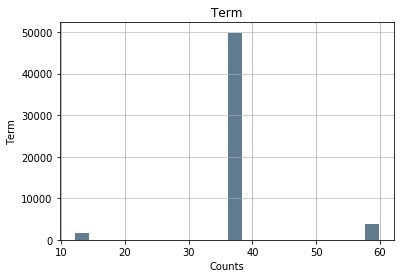

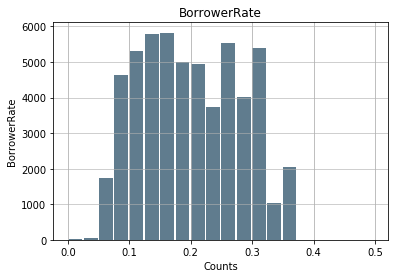

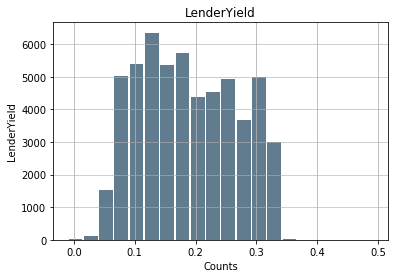

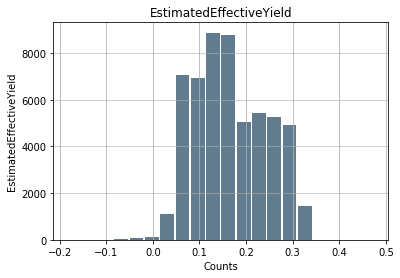

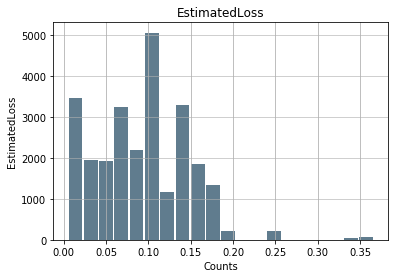

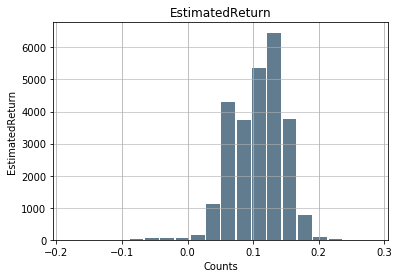

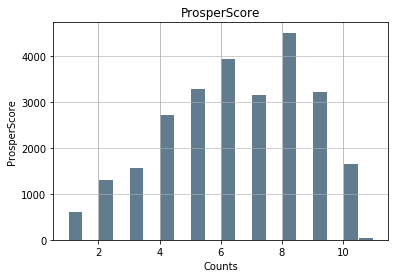

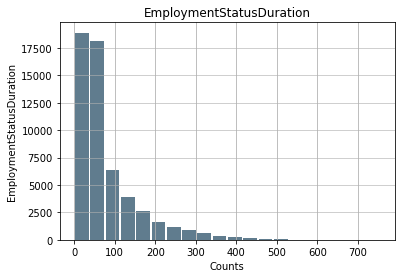

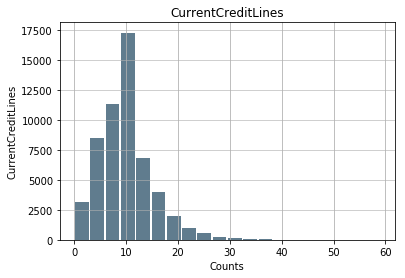

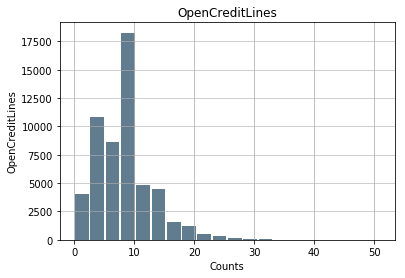

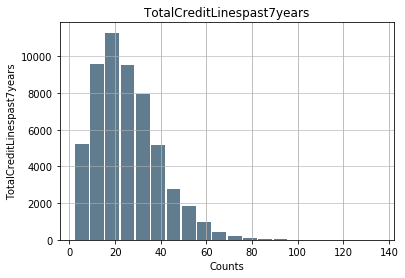

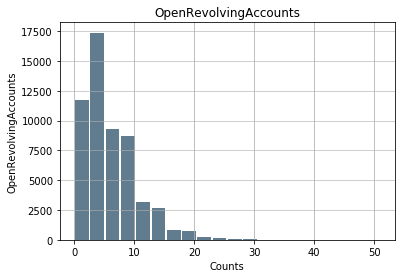

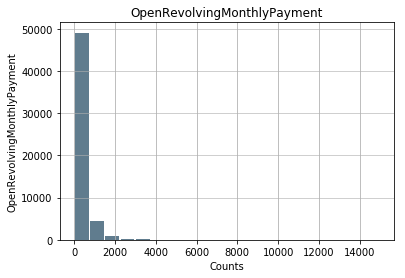

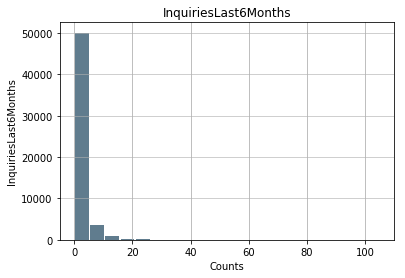

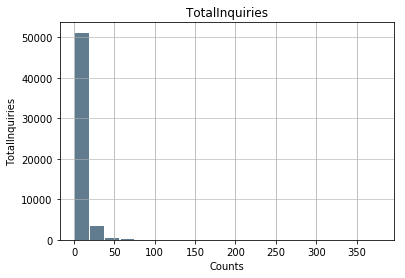

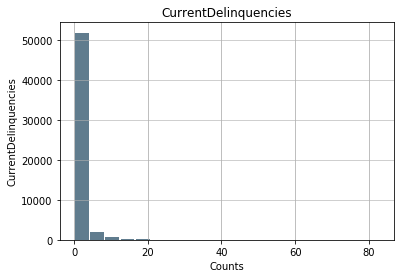

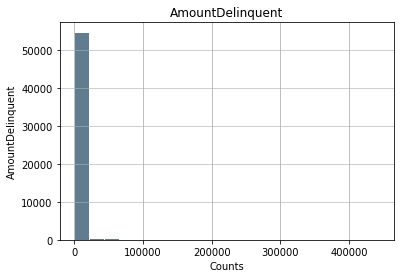

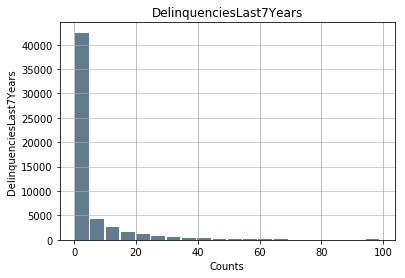

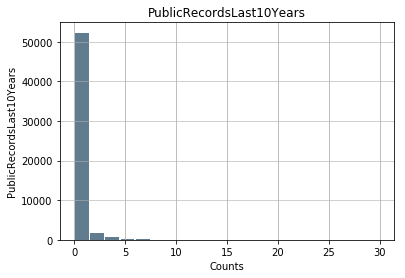

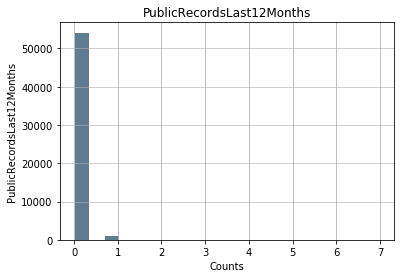

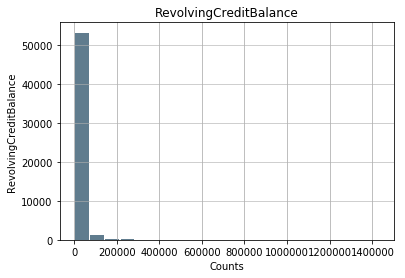

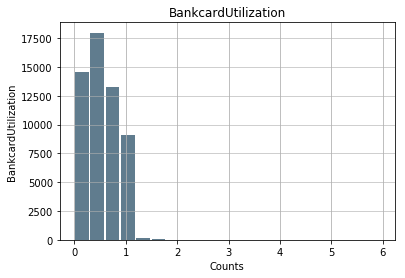

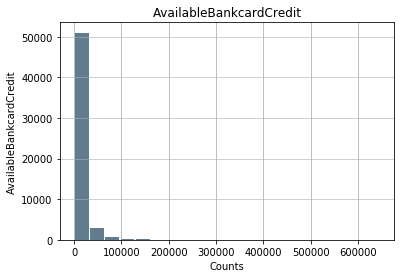

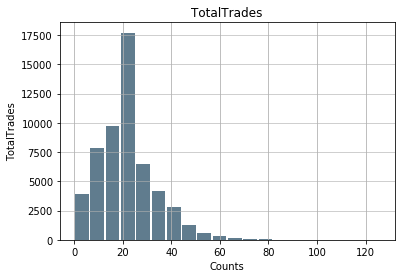

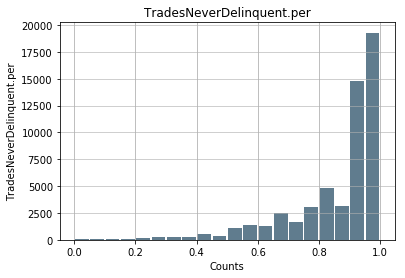

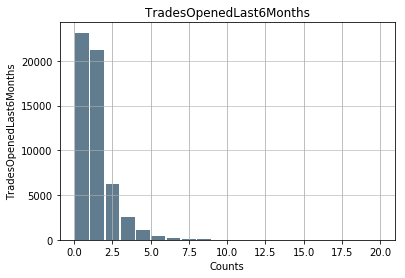

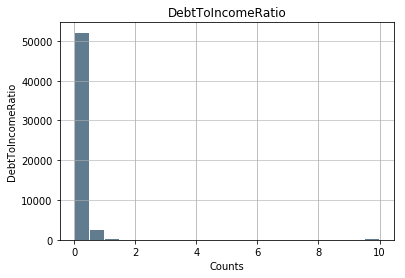

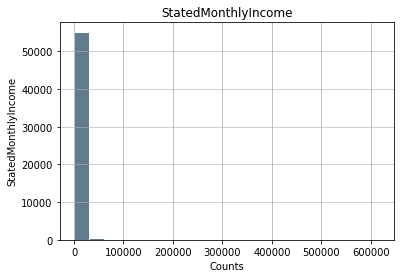

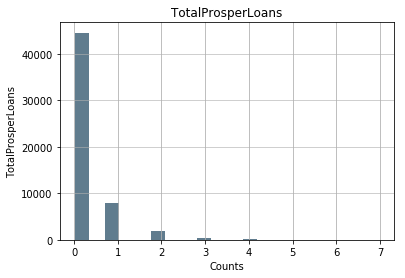

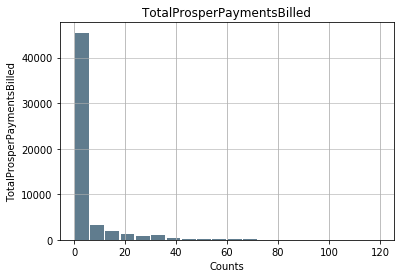

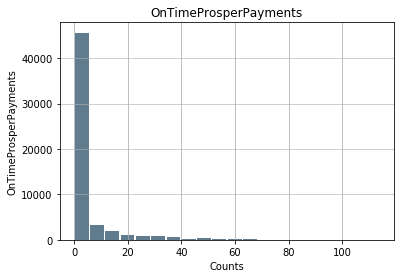

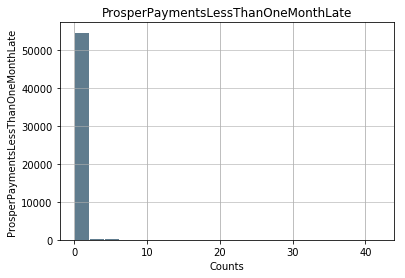

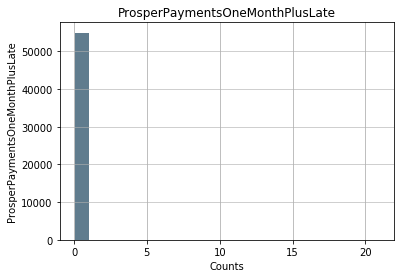

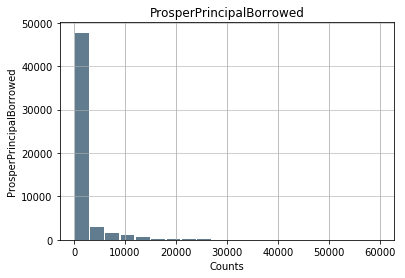

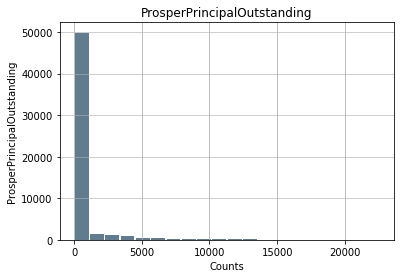

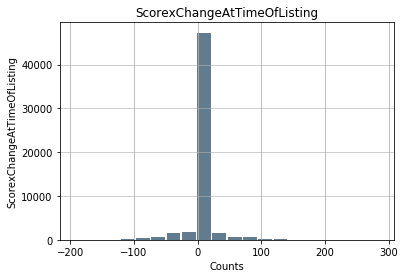

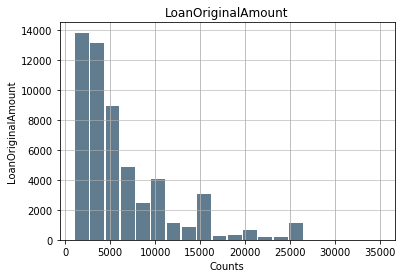

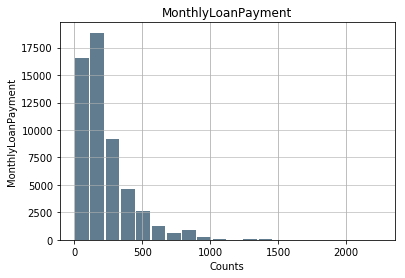

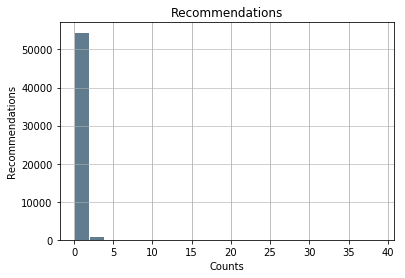

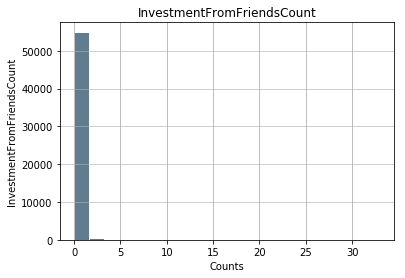

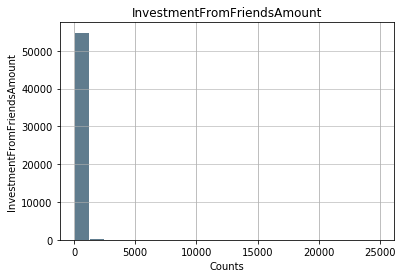

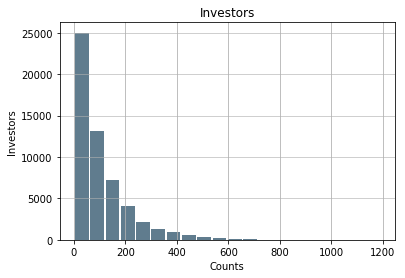

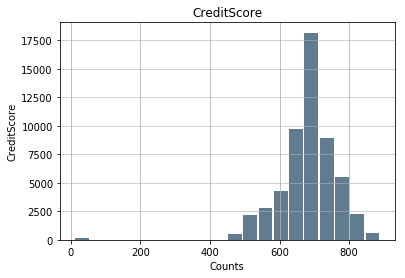

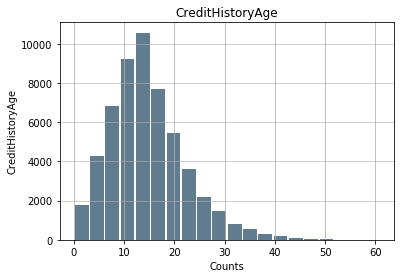

In [73]:
# Split the data into features and target label
completion = data["Completed.num"]
features_raw = data.drop("Completed.num", axis = 1)

# Visualize continuous features of original data
continuous_features = ["Term", "BorrowerRate", "LenderYield", "EstimatedEffectiveYield", 
                       "EstimatedLoss", "EstimatedReturn", "ProsperScore", "EmploymentStatusDuration", 
                       "CurrentCreditLines", "OpenCreditLines", "TotalCreditLinespast7years", 
                       "OpenRevolvingAccounts", "OpenRevolvingMonthlyPayment", "InquiriesLast6Months",
                       "TotalInquiries", "CurrentDelinquencies", "AmountDelinquent", "DelinquenciesLast7Years",
                       "PublicRecordsLast10Years", "PublicRecordsLast12Months", "RevolvingCreditBalance",
                       "BankcardUtilization", "AvailableBankcardCredit", "TotalTrades", 
                       "TradesNeverDelinquent.per", "TradesOpenedLast6Months", "DebtToIncomeRatio", 
                       "StatedMonthlyIncome", "TotalProsperLoans", "TotalProsperPaymentsBilled", 
                       "OnTimeProsperPayments", "ProsperPaymentsLessThanOneMonthLate", 
                       "ProsperPaymentsOneMonthPlusLate", "ProsperPrincipalBorrowed", 
                       "ProsperPrincipalOutstanding", "ScorexChangeAtTimeOfListing", "LoanOriginalAmount",
                       "MonthlyLoanPayment", "Recommendations", "InvestmentFromFriendsCount", 
                       "InvestmentFromFriendsAmount", "Investors", "CreditScore", "CreditHistoryAge"]

for feature in continuous_features:
    size, scale = 1000, 10
    data[feature].plot.hist(grid=True, bins=20, rwidth=0.9, color='#607c8e')
    plt.title(feature)
    plt.xlabel('Counts')
    plt.ylabel(feature)
    plt.grid(axis='y', alpha=0.75)
    plt.show()

Below, I perform a log-transformation on those features I noted to be skewed, adding a small number to `x`, since the logarithm of 0 is undefined.

/usr/lib/python3/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


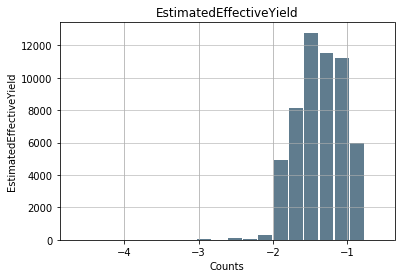

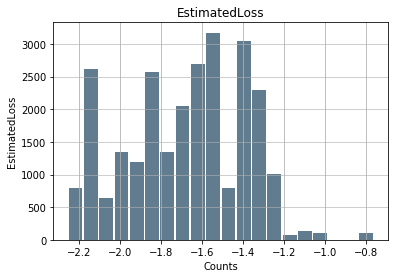

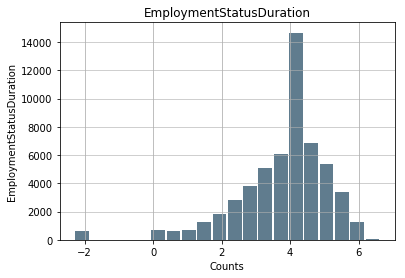

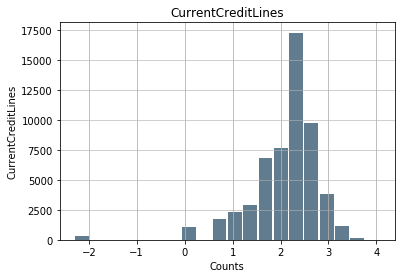

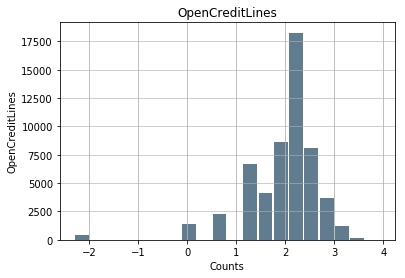

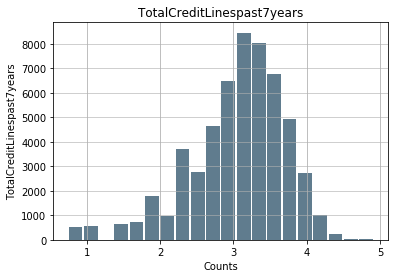

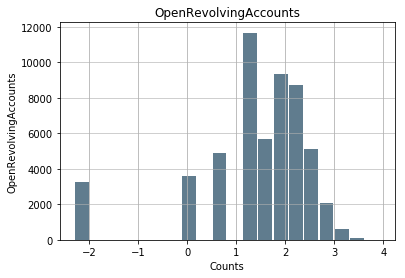

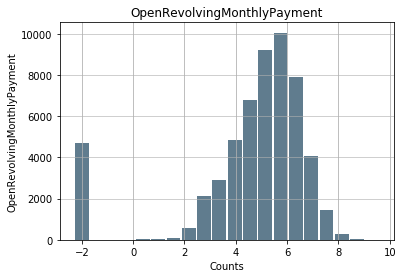

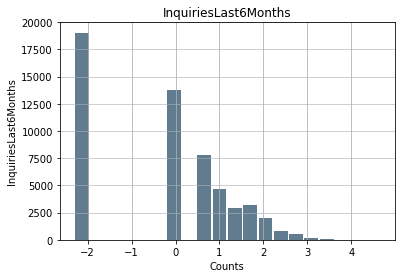

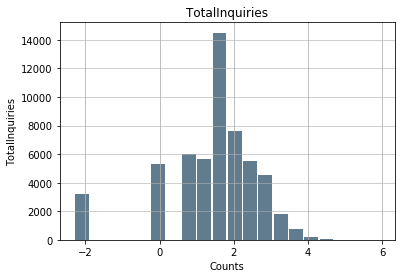

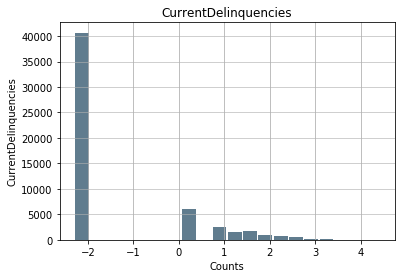

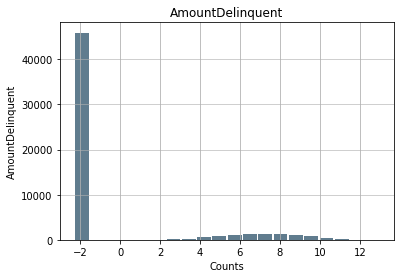

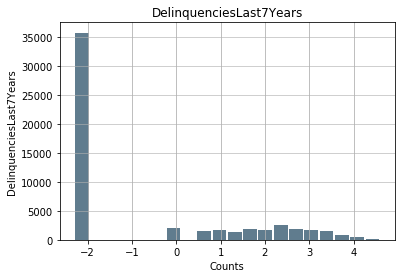

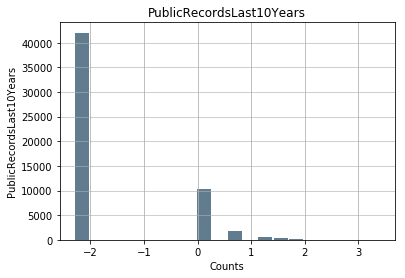

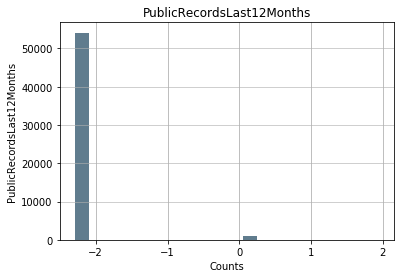

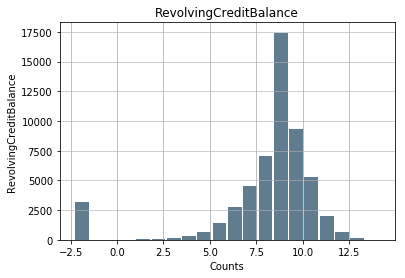

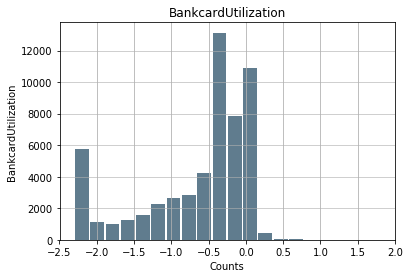

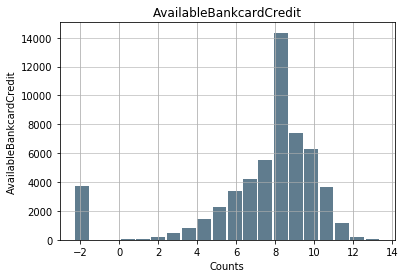

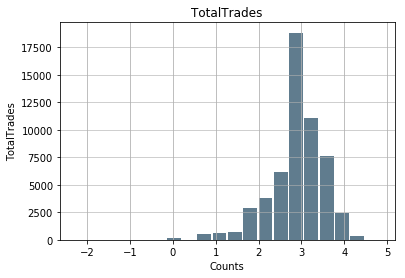

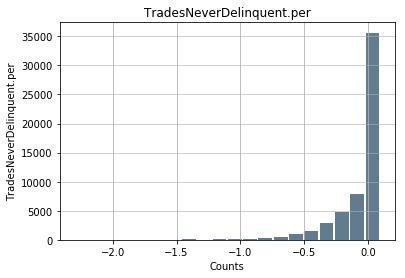

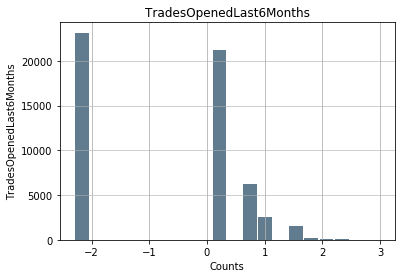

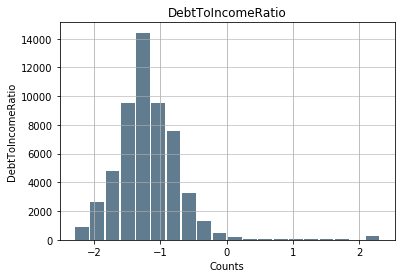

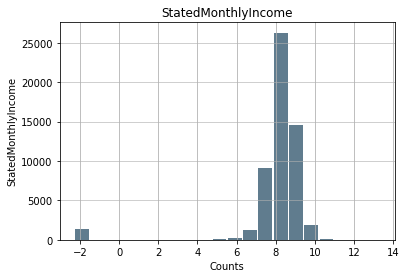

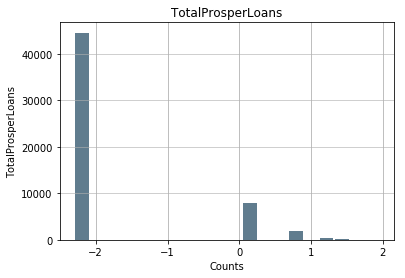

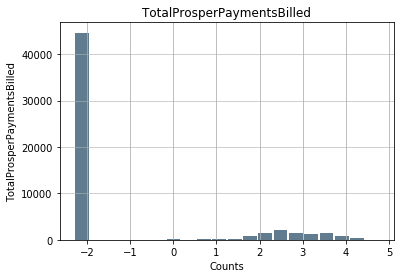

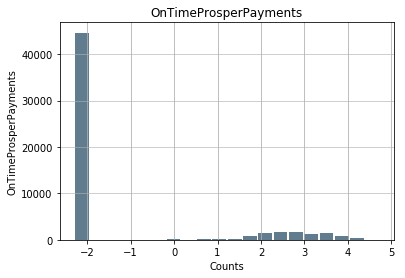

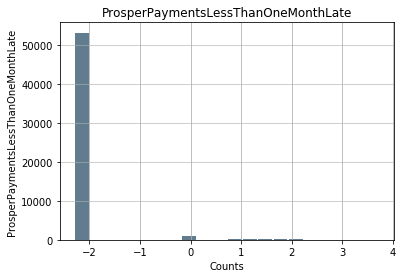

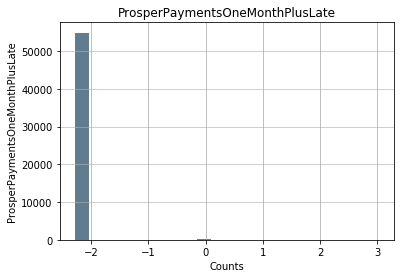

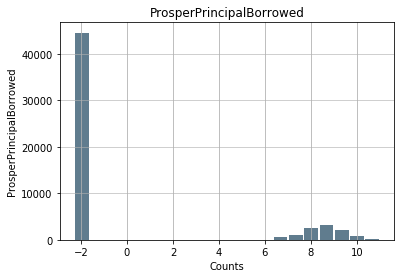

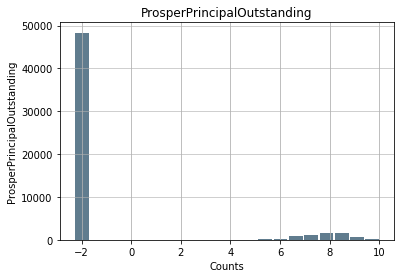

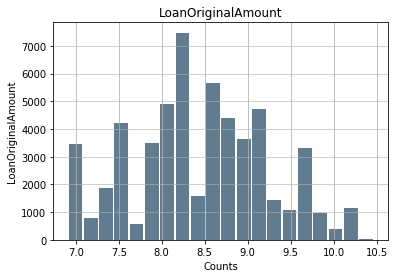

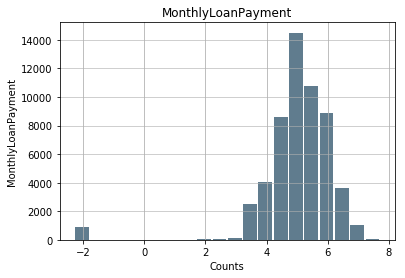

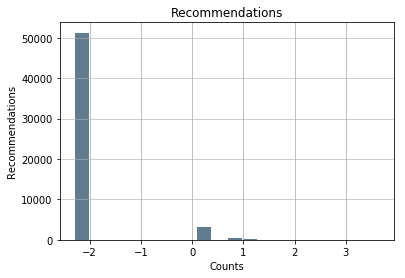

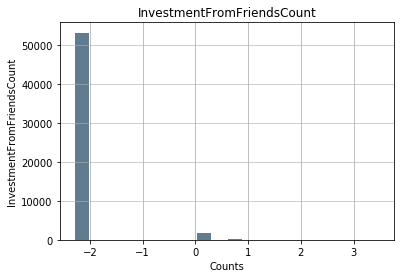

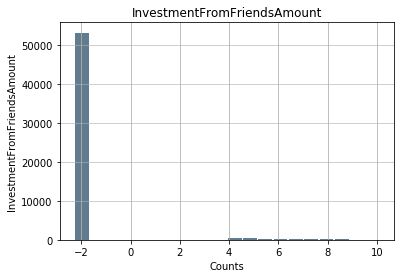

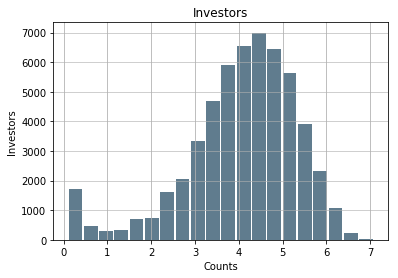

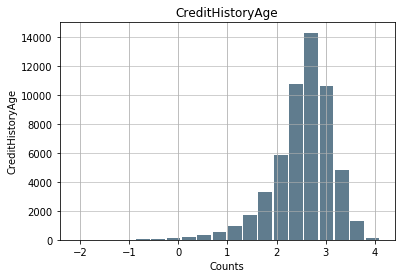

In [74]:
# Log-transform the skewed features
skewed = ['EstimatedEffectiveYield', 'EstimatedLoss', 'EmploymentStatusDuration', 'CurrentCreditLines',
          'OpenCreditLines', 'TotalCreditLinespast7years', 'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment',
          'InquiriesLast6Months', 'TotalInquiries', 'CurrentDelinquencies', 'AmountDelinquent', 
          'DelinquenciesLast7Years', 'PublicRecordsLast10Years', 'PublicRecordsLast12Months',
          'RevolvingCreditBalance', 'BankcardUtilization', 'AvailableBankcardCredit', 'TotalTrades',
          'TradesNeverDelinquent.per', 'TradesOpenedLast6Months', 'DebtToIncomeRatio', 'StatedMonthlyIncome',
          'TotalProsperLoans', 'TotalProsperPaymentsBilled', 'OnTimeProsperPayments', 
          'ProsperPaymentsLessThanOneMonthLate', 'ProsperPaymentsOneMonthPlusLate', 'ProsperPrincipalBorrowed',
          'ProsperPrincipalOutstanding', 'LoanOriginalAmount', 'MonthlyLoanPayment', 'Recommendations',
          'InvestmentFromFriendsCount', 'InvestmentFromFriendsAmount', 'Investors', 'CreditHistoryAge']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 0.1))

# Visualize the new log distributions
for feature in skewed:
    size, scale = 1000, 10
    features_log_transformed[feature].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
    plt.title(feature)
    plt.xlabel('Counts')
    plt.ylabel(feature)
    plt.grid(axis='y', alpha=0.75)
    plt.show()

Many of the features are still not normally distributed, but their values are by and large less extreme, and less likely to affect learning algorithms.  In the future, I will explore other transformations that can be applied to non-normally-distributed features.

### Coding Categorical Data

Since many learning algorithms only take numerical input, below I dummy-code categorical variables, with `0` indicating the absence of a feature/feature category, and `1` indicating its presence.

In [75]:
features_log_transformed.sample(10)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,CreditScore,CreditHistoryAge
26264,1311206400000000000,36,0.3099,0.2999,-0.951659,-1.469676,0.1561,5.0,Debt,Employed,3.139833,False,1311206400000000000,2.406945,2.406945,3.095578,2.091864,5.756059,-2.302585,0.741937,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,9.683346,0.076961,5.398615,3.000720,0.095310,0.741937,-0.820981,True,8.374115,0.095310,2.208274,2.208274,-2.302585,-2.302585,7.626132,7.425066,-13.0,8.922672,1311552000000000000,5.776320,-2.302585,-2.302585,-2.302585,1.410987,E,649.5,2.475617
51063,1347148800000000000,12,0.2254,0.2154,-1.185151,-1.437588,0.0682,2.0,Vacation,Self-employed,4.112512,True,1347148800000000000,2.949688,2.714695,3.972177,2.572612,6.234607,0.095310,2.208274,-2.302585,-2.302585,3.000720,-2.302585,-2.302585,9.116041,-0.371064,8.479927,3.914021,-0.061875,-2.302585,-1.203973,False,8.411855,0.741937,3.586293,3.586293,-2.302585,-2.302585,8.779573,7.994396,-13.0,8.294075,1347494400000000000,5.928312,-2.302585,-2.302585,-2.302585,3.049273,E,649.5,2.593720
36164,1255046400000000000,36,0.2575,0.2475,-1.413049,-1.619488,0.1434,7.0,Business,Full-time,4.220977,False,1283385600000000000,1.629241,1.410987,2.895912,1.629241,6.255942,-2.302585,1.629241,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,9.575685,-0.083382,8.016351,2.778819,-0.094311,-2.302585,-1.139434,True,8.740353,0.741937,3.914021,3.873282,0.741937,-2.302585,10.308956,7.851731,-33.0,8.922672,1285027200000000000,5.674113,0.095310,-2.302585,-2.302585,5.517854,D,669.5,2.911680
41112,1341446400000000000,60,0.2870,0.2770,-0.993982,-1.518684,0.1511,6.0,Reno,Employed,3.852273,False,1341014400000000000,2.091864,2.091864,2.312535,2.091864,5.442851,0.095310,1.808289,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,9.333098,-1.272966,10.839465,2.312535,0.095310,0.095310,-1.203973,False,9.210350,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.0,9.615812,1343347200000000000,6.160131,-2.302585,-2.302585,-2.302585,5.273512,D,709.5,2.521996
12742,1222214400000000000,36,0.3000,0.2900,-0.977103,NaN,NaN,NaN,Other,Full-time,3.049273,False,1221609600000000000,2.646175,2.646175,2.778819,2.572612,6.470954,0.095310,1.629241,-2.302585,-2.302585,-2.302585,0.095310,-2.302585,10.033862,-0.127833,8.651042,2.778819,0.095310,0.095310,-0.733969,True,8.027700,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.0,7.313287,1222905600000000000,4.155440,-2.302585,-2.302585,-2.302585,3.808882,E,589.5,2.137484
8928,1212969600000000000,36,0.1484,0.1384,-1.492544,NaN,NaN,NaN,Personal,Full-time,3.716008,True,1212192000000000000,1.960095,1.960095,2.493205,1.410987,6.140100,1.410987,2.493205,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,9.637247,-0.579818,9.785554,2.493205,0.095310,-2.302585,-0.693147,True,8.150978,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.0,9.179891,1213660800000000000,5.815890,-2.302585,-2.302585,-2.302585,5.318610,A,749.5,2.283919
53970,1206662400000000000,36,0.2927,0.2827,-0.996688,Na

Below, I dummy-code all categorical features:

In [76]:
# dummy-code the log-transformed features
features_final = pd.get_dummies(features_log_transformed)

# Print the number of features after dummy-coding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

print(encoded)

88 total features after one-hot encoding.
['ListingCreationDate', 'Term', 'BorrowerRate', 'LenderYield', 'EstimatedEffectiveYield', 'EstimatedLoss', 'EstimatedReturn', 'ProsperScore', 'EmploymentStatusDuration', 'IsBorrowerHomeowner', 'DateCreditPulled', 'CurrentCreditLines', 'OpenCreditLines', 'TotalCreditLinespast7years', 'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment', 'InquiriesLast6Months', 'TotalInquiries', 'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years', 'PublicRecordsLast10Years', 'PublicRecordsLast12Months', 'RevolvingCreditBalance', 'BankcardUtilization', 'AvailableBankcardCredit', 'TotalTrades', 'TradesNeverDelinquent.per', 'TradesOpenedLast6Months', 'DebtToIncomeRatio', 'IncomeVerifiable', 'StatedMonthlyIncome', 'TotalProsperLoans', 'TotalProsperPaymentsBilled', 'OnTimeProsperPayments', 'ProsperPaymentsLessThanOneMonthLate', 'ProsperPaymentsOneMonthPlusLate', 'ProsperPrincipalBorrowed', 'ProsperPrincipalOutstanding', 'ScorexChangeAtTimeOfListing

## Dimensionality Reduction

In this section, I use principal component analysis (PCA) to see if the features in my dataset can be reduced to fewer dimensions, which may improve algorithm performance, and reduce feature redundancy.

Below, I split the data into training and testing datasets.

In [77]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

X_train, X_test, y_train, y_test = train_test_split(features_final, completion, test_size=0.15, random_state=42)

### Normalizing Numerical Features

Prior to using PCA, I scale all numerical features, which ensures that algorithms treat features equally, rather than giving some undue weight.

In [78]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # default=(0, 1)

X_train_scaled = X_train
X_train_scaled[continuous_features] = scaler.fit_transform(X_train[continuous_features])

X_test_scaled = X_test
X_test_scaled[continuous_features] = scaler.fit_transform(X_test[continuous_features])

/home/eskrav/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/eskrav/.local/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/eskrav/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:3

In [79]:
# Show the results of the split
print("Training set has {} samples.".format(X_train_scaled.shape[0]))
print("Testing set has {} samples.".format(X_test_scaled.shape[0]))

Training set has 46821 samples.
Testing set has 8263 samples.


Below, I drop all columns with remaining missing values, and save the data to a separate testing/training set which can be used with algorithms which handle missing data natively.

In [80]:
X_test_scaled.sample(10)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,CreditScore,CreditHistoryAge,ListingCategory_Auto,ListingCategory_Baby,ListingCategory_Boat,ListingCategory_Business,ListingCategory_Cosmetic,ListingCategory_Debt,ListingCategory_Engagement,ListingCategory_Green,ListingCategory_Household,ListingCategory_LargePurchase,ListingCategory_Medical,ListingCategory_Motorcycle,ListingCategory_Other,ListingCategory_Personal,ListingCategory_RV,ListingCategory_Reno,ListingCategory_Student,ListingCategory_Taxes,ListingCategory_Unknown,ListingCategory_Vacation,ListingCategory_Wedding,EmploymentStatus_Employed,EmploymentStatus_Full-time,EmploymentStatus_Not available,EmploymentStatus_Not employed,EmploymentStatus_Other,EmploymentStatus_Part-time,EmploymentStatus_Retired,EmploymentStatus_Self-employed,EmploymentStatus_Unknown,Rating_A,Rating_AA,Rating_B,Rating_C,Rating_D,Rating_E,Rating_HR,Rating_NC,Rating_Unknown
36118,1319155200000000000,0.5,0.888611,0.876438,0.969110,0.621470,0.652347,0.0,0.840512,True,1319155200000000000,0.770207,0.797713,0.705866,0.765173,0.835925,0.565121,0.499190,0.000000,0.000000,0.000000,0.0,0.0,0.815670,0.527300,0.803826,0.746029,0.988468,0.000000,0.237995,False,0.748330,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.445977,0.389908,1319760000000000000,0.744699,0.000000,0.000000,0.000000,0.434560,0.863636,0.882494,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
748,1322784000000000000,0.5,0.882500,0.870411,0.967574,0.621470,0.647697,0.2,0.793059,True,1322784000000000000,0.879110,0.883284,0.890936,0.835383,0.738216,0.344649,0.416994,0.000000,0.000000,0.000000,0.0,0.0,0.721588,0.477764,0.734149,0.909893,0.984553,0.819849,0.352947,True,0.678429,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.445977,0.389908,1323820800000000000,0.744418,0.000000,0.000000,0.000000,0.316035,0.795455,0.838738,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
41746,1352160000000000000,1.0,0.562222,0.554521,0.874473,0.282690,0.640611,0.7,0.461974,False,1352160000000000000,0.586688,0.498166,0.489567,0.494654,0.601675,0.000000,0.291180,0.375739,0.460511,0.000000,0.0,0.0,0.645319,0.467241,0.677176,0.549546,0.882547,0.000000,0.230651,True,0.672071,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.445977,0.842595,1353456000000000000,0.856163,0.000000,0.000000,0.000000,0.847147,0.795455,0.783467,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
29045,1218412800000000000,0.5,0.222222,0.219178,0.706678,NaN,NaN,NaN,0.835318,True,1218412800000000000,0.757662,0.784720,0.634703,0.749834,0.602392,0.000000,0.291180,0.000000,0.000000,0.441317,0.0,0.0,0.534325,0.098830,0.760724,0.673786,0.834682,0.000000,0.150158,True,0.727690,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.445977,0.403631,1219190400000000000,0.716743,0.000000,0.000000,0.000000,0.724970,0.886364,0.754156,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5946,1213660800000000000,0.5,0.430556,0.424658,0.818654,NaN,NaN,NaN,0.652033,True,1213056000000000000,0.812305

In [81]:
X_train_non_na = X_train_scaled.drop(['EstimatedEffectiveYield', 'EstimatedLoss',
                                      'EstimatedReturn', 'ProsperScore'], axis=1)
X_test_non_na = X_test_scaled.drop(['EstimatedEffectiveYield', 'EstimatedLoss',
                                    'EstimatedReturn', 'ProsperScore'], axis=1)

X_train_full = X_train_scaled
X_test_full = X_test_scaled

### Applying Dimensionality Reduction

Below, I reduce the features to 10 components, and then 3 components.  I further reduce the dataset to the top 30% of most important features (those that account for the most variance), and to the top 10%.  All are saved to separate testing/training sets.

In [82]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10, random_state=42)
pca.fit(X_train_non_na)

X_train_pca10 = pca.transform(X_train_non_na)
X_test_pca10 = pca.transform(X_test_non_na)

pca.explained_variance_ratio_

array([9.99553652e-01, 4.25776825e-04, 2.05712758e-05, 2.80739588e-35,
       2.24526551e-35, 1.80332701e-35, 1.50397138e-35, 1.47234153e-35,
       1.30534416e-35, 1.12288385e-35])

In [83]:
pca = PCA(n_components=3, random_state=42)
pca.fit(X_train_non_na)

X_train_pca3 = pca.transform(X_train_non_na)
X_test_pca3 = pca.transform(X_test_non_na)

pca.explained_variance_ratio_

array([9.99553652e-01, 4.25776825e-04, 2.05712758e-05])

In [84]:
from sklearn.feature_selection import SelectPercentile

X_train_reduce30 = SelectPercentile(percentile=30).fit_transform(X_train_non_na, y_train)
X_test_reduce30 = SelectPercentile(percentile=30).fit_transform(X_test_non_na, y_test)

X_train_reduce10 = SelectPercentile(percentile=10).fit_transform(X_train_non_na, y_train)
X_test_reduce10 = SelectPercentile(percentile=10).fit_transform(X_test_non_na, y_test)

Above, it looks like the most important feature accounts for quite a bit of the variance, and the rest account for comparatively tiny portions.  This may make the use of a highly reduced dataset feasible.

----
## Evaluating Model Performance


### The Naive Predictor

Below, we look at how a simple model, which always predicts that a loan was completed, performs.  Although the accuracy and F-score in this case is rather high, and the general goal is to maximize recall (identify all defaults), it is clear that this model performs rather poorly.  An improved model must have higher precision, even if at the expense of recall -- particularly given that lenders should be more wary of investing in loans unlikely to pay off, even if this involves risk of not investing in high-yield loans.

In [85]:
# true positives
TP = np.sum(completion)
# false positives
FP = completion.count() - TP

# true negatives
TN = 0
# false negatives
FN = 0

# accuracy, precision and recall
accuracy = TP/(TP+FP)
recall = TP/(TP+FN)
precision = TP/(TP+FP)

# F-score for beta = 1
fscore = (1+1**2) * (precision * recall)/(1**2 * precision + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}, Precision: {:.4f}, Recall: {:.4f}]".format(accuracy, fscore, precision, recall))

Naive Predictor: [Accuracy score: 0.6912, F-score: 0.8174, Precision: 0.6912, Recall: 1.0000]


## Model Application


I picked three Ensemble methods commonly used for the task of classification - one averaging method, and two boosting methods.  I also picked Logistic Regression, as having an output of probabilities allows for more interpretability, and flexibility after the fact in setting thresholds for decisions.  I broadly retain some of my previous descriptions of these model types, where I have previously used them.

For strengths and weaknesses of the relevant models, I primarily consulted the following sources, keeping in mind that heuristics do not necessarily apply to each data set:

https://medium.com/@randylaosat/machine-learning-whats-inside-the-box-861f5c7e72a3

https://medium.com/@vijaya.beeravalli/comparison-of-machine-learning-classification-models-for-credit-card-default-data-c3cf805c9a5a

https://www.dummies.com/programming/big-data/data-science/machine-learning-dummies-cheat-sheet/

https://hackernoon.com/boosting-algorithms-adaboost-gradient-boosting-and-xgboost-f74991cad38c

https://medium.com/@grohith327/gradient-boosting-and-xgboost-90862daa6c77

#### Ensemble Methods: Random Forest

The strengths of this model are the following: it natively handles categorical variables; it is less prone to overfitting than a single decision tree -- therefore, it is more likely to select relevant features; and it frequently outperforms other methods on accuracy.  **These features make this model a good candidate for this problem, which has numerous categorical and continuous features.  Given that after one-hot conversion, there were 88 total features, a model which will automatically select the most important features is of particular importance.**  Additionally, it can handle imbalanced data, such as this dataset, and is a flexible algorithm that does not require a lot of parameter tuning.

The weaknesses of this model are that it won't perform well with a bad set of features; it's not very transparent, and it's hard to interpret what's going on in the algorithm; further, too many trees can slow down the algorithm.

#### Ensemble Methods: AdaBoost

AdaBoost is particularly well-suited for boosting the performance of decision trees on binary classification tasks.  It typically does not overfit despite excellent accuracy (although it is to date unclear exactly how), and frequently outperforms other methods.  **These features make it a good model to attempt for this problem, given that the algorithm can be used to boost the performance of classifiers that work well natively with categorical data, such as decision trees, and like RF will automatically select those features that are most important.**  It additionally can handle missing variables, and does not require variable transformation, and has relatively few parameters that need tweaking.

The weaknesses of this model are that it does not deal well with noisy data, and the efficiency of the algorithm is affected by outliers, since the algorithm attempts to fit each point.

#### Logistic Regression

The strengths of this model are that it's fairly easy to interpret in terms of probabilities; relatively unlikely to overfit; fast; well-suited for binary classification tasks; and explanatory variables can be continuous or categorical.  **These features, and in particular the fact that results are probabilities, make this model a good candidate for this problem, since probabilities allow for post-hoc adjustment of the threshold for whether a lender should fund a particular loan, perhaps depending on their personal finances or risk aversion.**

The downsides of this model are that it's not particularly good at capturing complex or non-linear relationships between features, or dealing with multiple/non-linear decision boundaries; generally, it's not very flexible.

#### Ensemble Methods: XGBoost

XGBoost, which was recommended by a reviewer, is highly robust to irregularities in data, and like AdaBoost, is a boosting algorithm which tries to create a strong classifier from a series of weaker classifiers.  **Given that the dataset I have is quite noisy, with quite a bit of missing or imputed data, and is particularly suited to decision trees, this algorithm would be appropriate to try.**

### Training and Predicting Pipeline

Below I use a training function from another Udacity project to evaluate the peformance of the various classifiers, with repect to time and various metrics, on testing and training data.

In [86]:
from sklearn.metrics import fbeta_score, accuracy_score, f1_score, precision_score, recall_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    results['train_time'] = end - start
        
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    results['pred_time'] = end - start
            
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train[:300])
        
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    results['f_train'] = f1_score(y_train[:300], predictions_train[:300])
        
    results['f_test'] = f1_score(y_test, predictions_test)
    
    results['p_train'] = precision_score(y_train[:300], predictions_train[:300])
        
    results['p_test'] = precision_score(y_test, predictions_test)
    
    results['r_train'] = recall_score(y_train[:300], predictions_train[:300])
        
    results['r_test'] = recall_score(y_test, predictions_test)
       
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    return results

### Model Evaluation


#### Full dataset without missing data

In [87]:
from time import time

clf_A = RandomForestClassifier(random_state = 42)
clf_B = AdaBoostClassifier(random_state = 42)
clf_C = LogisticRegression(random_state = 42)
clf_D = XGBClassifier(random_state = 42)

samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

results_non_na = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results_non_na[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results_non_na[clf_name][i] = \
        train_predict(clf, samples, X_train_non_na, y_train, X_test_non_na, y_test)

/home/eskrav/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier trained on 468 samples.
RandomForestClassifier trained on 4682 samples.
RandomForestClassifier trained on 46821 samples.
AdaBoostClassifier trained on 468 samples.
AdaBoostClassifier trained on 4682 samples.
AdaBoostClassifier trained on 46821 samples.
LogisticRegression trained on 468 samples.
LogisticRegression trained on 4682 samples.


/home/eskrav/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/eskrav/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/eskrav/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression trained on 46821 samples.
XGBClassifier trained on 468 samples.
XGBClassifier trained on 4682 samples.
XGBClassifier trained on 46821 samples.


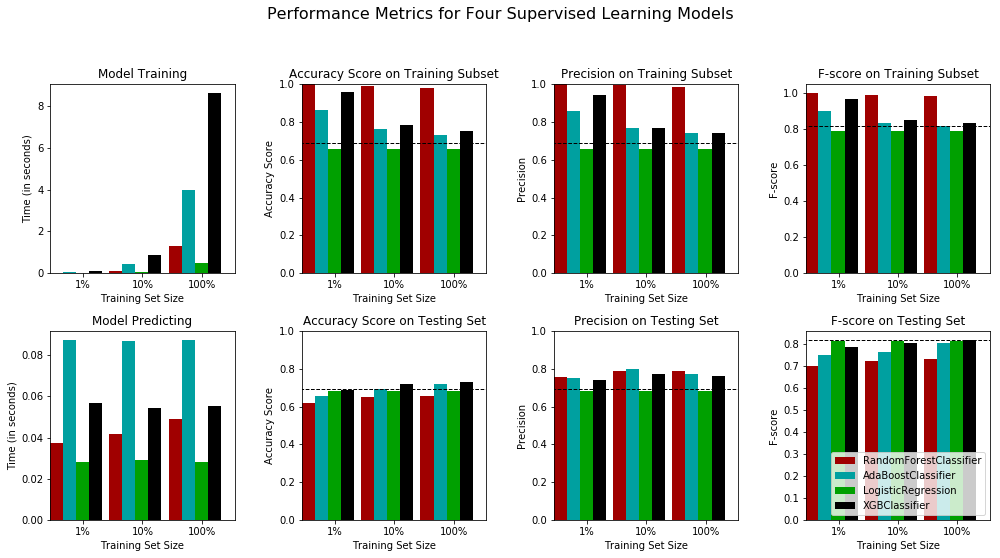

In [88]:
vs.evaluate(results_non_na, accuracy, precision, fscore)

#### PCA: 10 most important features

In [89]:
clf_A = RandomForestClassifier(random_state = 42)
clf_B = AdaBoostClassifier(random_state = 42)
clf_C = LogisticRegression(random_state = 42)
clf_D = XGBClassifier(random_state = 42)

samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

results_pca10 = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results_pca10[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results_pca10[clf_name][i] = \
        train_predict(clf, samples, X_train_pca10, y_train, X_test_pca10, y_test)

/home/eskrav/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier trained on 468 samples.
RandomForestClassifier trained on 4682 samples.
RandomForestClassifier trained on 46821 samples.
AdaBoostClassifier trained on 468 samples.
AdaBoostClassifier trained on 4682 samples.
AdaBoostClassifier trained on 46821 samples.
LogisticRegression trained on 468 samples.
LogisticRegression trained on 4682 samples.
LogisticRegression trained on 46821 samples.


/home/eskrav/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/eskrav/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/eskrav/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


XGBClassifier trained on 468 samples.
XGBClassifier trained on 4682 samples.
XGBClassifier trained on 46821 samples.


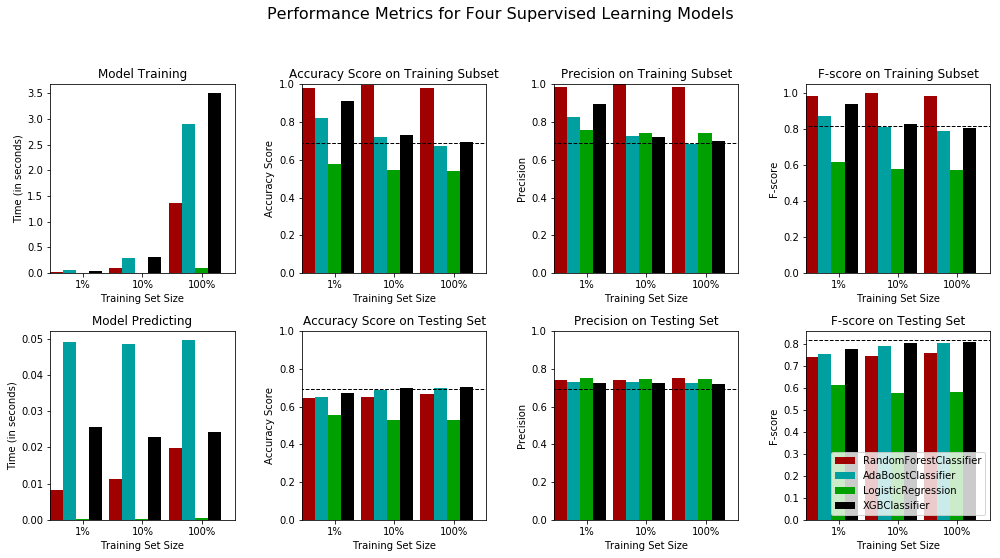

In [90]:
vs.evaluate(results_pca10, accuracy, precision, fscore)

#### PCA: 3 most important features

In [91]:
clf_A = RandomForestClassifier(random_state = 42)
clf_B = AdaBoostClassifier(random_state = 42)
clf_C = LogisticRegression(random_state = 42)
clf_D = XGBClassifier(random_state = 42)

samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

results_pca3 = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results_pca3[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results_pca3[clf_name][i] = \
        train_predict(clf, samples, X_train_pca3, y_train, X_test_pca3, y_test)

/home/eskrav/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier trained on 468 samples.
RandomForestClassifier trained on 4682 samples.
RandomForestClassifier trained on 46821 samples.
AdaBoostClassifier trained on 468 samples.
AdaBoostClassifier trained on 4682 samples.
AdaBoostClassifier trained on 46821 samples.
LogisticRegression trained on 468 samples.
LogisticRegression trained on 4682 samples.
LogisticRegression trained on 46821 samples.
XGBClassifier trained on 468 samples.


/home/eskrav/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/eskrav/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/eskrav/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


XGBClassifier trained on 4682 samples.
XGBClassifier trained on 46821 samples.


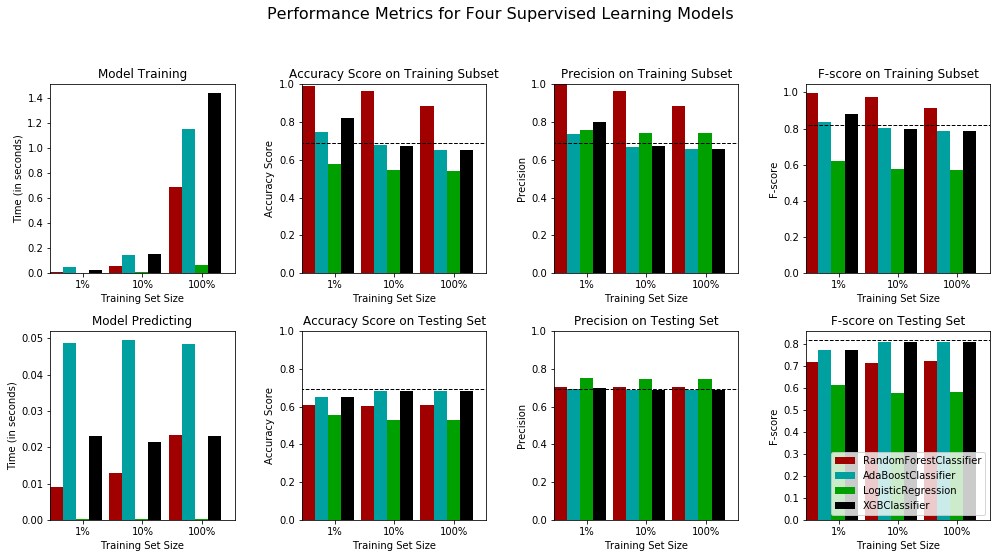

In [92]:
vs.evaluate(results_pca3, accuracy, precision, fscore)

#### PCA: top 30% of features

In [93]:
clf_A = RandomForestClassifier(random_state = 42)
clf_B = AdaBoostClassifier(random_state = 42)
clf_C = LogisticRegression(random_state = 42)
clf_D = XGBClassifier(random_state = 42)

samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

results_reduce30 = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results_reduce30[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results_reduce30[clf_name][i] = \
        train_predict(clf, samples, X_train_reduce30, y_train, X_test_reduce30, y_test)

/home/eskrav/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier trained on 468 samples.
RandomForestClassifier trained on 4682 samples.
RandomForestClassifier trained on 46821 samples.
AdaBoostClassifier trained on 468 samples.
AdaBoostClassifier trained on 4682 samples.
AdaBoostClassifier trained on 46821 samples.
LogisticRegression trained on 468 samples.
LogisticRegression trained on 4682 samples.


/home/eskrav/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/eskrav/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/eskrav/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression trained on 46821 samples.
XGBClassifier trained on 468 samples.
XGBClassifier trained on 4682 samples.
XGBClassifier trained on 46821 samples.


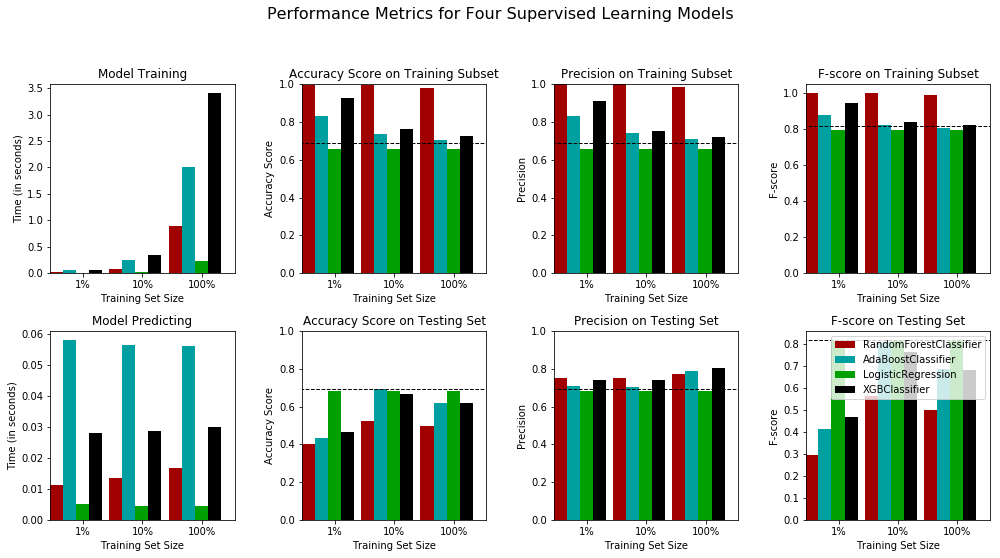

In [94]:
vs.evaluate(results_reduce30, accuracy, precision, fscore)

#### PCA: top 10% of features

In [95]:
clf_A = RandomForestClassifier(random_state = 42)
clf_B = AdaBoostClassifier(random_state = 42)
clf_C = LogisticRegression(random_state = 42)
clf_D = XGBClassifier(random_state = 42)

samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

results_reduce10 = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results_reduce10[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results_reduce10[clf_name][i] = \
        train_predict(clf, samples, X_train_reduce10, y_train, X_test_reduce10, y_test)

/home/eskrav/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier trained on 468 samples.
RandomForestClassifier trained on 4682 samples.
RandomForestClassifier trained on 46821 samples.
AdaBoostClassifier trained on 468 samples.
AdaBoostClassifier trained on 4682 samples.
AdaBoostClassifier trained on 46821 samples.
LogisticRegression trained on 468 samples.
LogisticRegression trained on 4682 samples.
LogisticRegression trained on 46821 samples.


/home/eskrav/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/eskrav/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/eskrav/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


XGBClassifier trained on 468 samples.
XGBClassifier trained on 4682 samples.
XGBClassifier trained on 46821 samples.


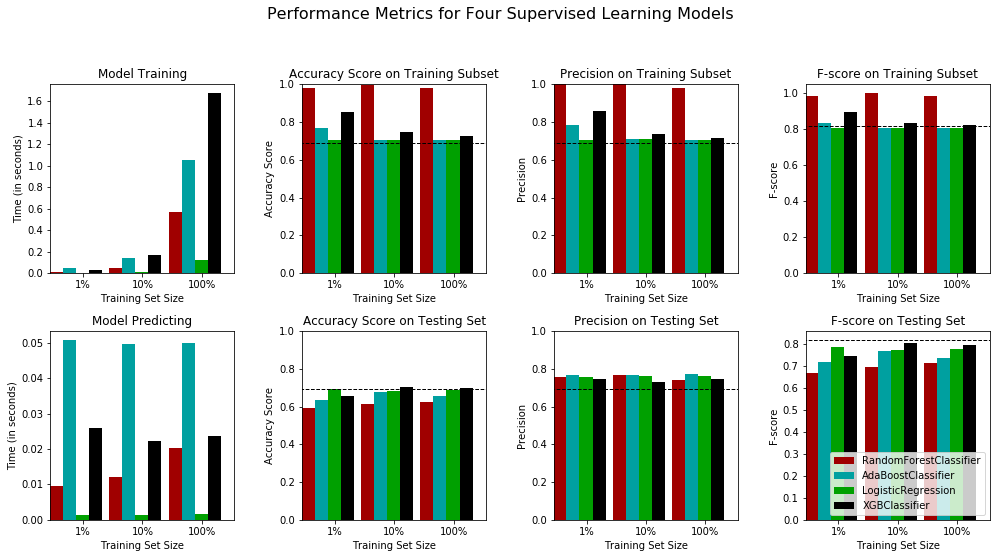

In [96]:
vs.evaluate(results_reduce10, accuracy, precision, fscore)

#### Full dataset with missing data (XGBoost only, which unlike AdaBoost handles missing values)

In [97]:
clf_A = XGBClassifier(random_state = 42)

samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

results_full = {}
for clf in [clf_A]:
    clf_name = clf.__class__.__name__
    results_full[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results_full[clf_name][i] = \
        train_predict(clf, samples, X_train_full, y_train, X_test_full, y_test)

XGBClassifier trained on 468 samples.
XGBClassifier trained on 4682 samples.
XGBClassifier trained on 46821 samples.


In [98]:
results_spliced = results_non_na
results_spliced["XGBClassifier_full"] = results_full["XGBClassifier"]

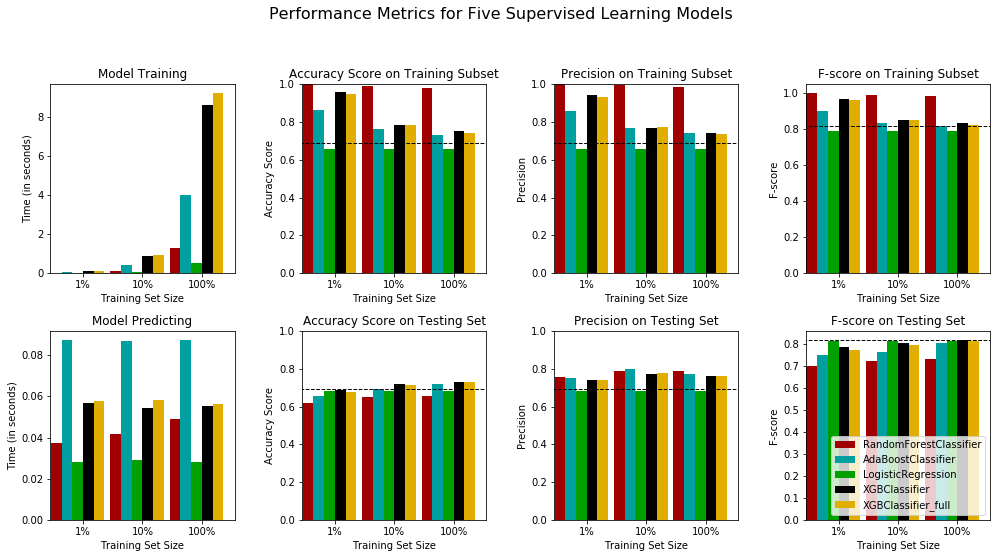

In [ ]:
vs.evaluate5(results_spliced, accuracy, precision, fscore)

----
## Optimizing Results

**AdaBoost and XGBoost perform roughly similarly on the testing data, and generally appear superior to the Random Forest model, which overfits the training data, or Logistic Regression, which shows inferior performance on the testing data.  Although AdaBoost trained faster, the two algorithms generally showed similar performance on the F1 metric, Recall, and Precision, with a slight edge for XGBoost on the last.  Both are similarly well-suited for the a large number of continuous and categorical variables, as seen in this dataset, given that ensemble methods will pick out the most important features, and decision tree-based classifiers are paticularly well-suited to categorical data.  It is difficult to choose between AdaBoost and XGBoost; AdaBoost is able to achieve high precision scores alongside reasonably high recall and F1 scores on the full dataset, and does so faster than XGBoost.  However, XGBoost has a slight edge on precision, arguably the most important metric, and is more robust to noisy data (as well as being able to handle missing data).  Below, I briefly discuss how both methods work.**

**AdaBoost takes a family of weak classifiers, which may perform only slightly better than chance at correctly classifying any given point, combines them, and lets them 'vote' on the correct category of any given point.  When a large number of such weak classifiers vote on any given point, the chance that this point will be correctly classified increases significantly.  By default, AdaBoost uses decision tree classifiers to classify points, although it can use different base classifiers.  The process of classifying points continues either until each point is correctly classified in a labeled data set, or until the maximum number of iterations specified is reached.**

**The image below illustrates this: a weak classifier in Box 1 classifies several of the positive points correctly, but misclassifies the rest of the positive points.  The weights of the misclassified samples are then increased, and the next weak classifier (Box 2) is more likely to classify these points correctly.  The weights of misclassified samples is increased again, and the process repeats.  In the end, the weak classifiers are combined, and 'vote' on the category a given point belongs to:**

![Image](image.png)

**The drawback of this method, as mentioned, is that it does not deal well with noisy data, given that it attempts to categorize all points correctly.  It is not, however, prone to overfitting, although the reason for this is not clear.**

**XGBoost (........................)**

Resources:

https://hackernoon.com/boosting-algorithms-adaboost-gradient-boosting-and-xgboost-f74991cad38c (image copied from this resource)

### Model Tuning (AdaBoost)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

clf = AdaBoostClassifier(random_state=42)

parameters = dict(n_estimators=[10, 50, 100, 250, 500, 1000], 
                  learning_rate=[0.01, 0.05, 0.1, 0.5, 1],
                  algorithm=['SAMME', 'SAMME.R'])

scorer = {'F1': make_scorer(f1_score), 
          'Precision': make_scorer(precision_score), 
          'Recall': make_scorer(recall_score)}

grid_obj = GridSearchCV(clf, param_grid = parameters, scoring=scorer, refit='Precision')

grid_fit = grid_obj.fit(X_train_non_na, y_train)

best_adaboost_clf = grid_fit.best_estimator_

adaboost_predictions = (clf.fit(X_train_non_na, y_train)).predict(X_test_non_na)
best_adaboost_predictions = best_adaboost_clf.predict(X_test_non_na)

/home/eskrav/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [ ]:
best_adaboost_clf.get_params()

In [ ]:
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, adaboost_predictions)))
print("F-score on testing data: {:.4f}".format(f1_score(y_test, adaboost_predictions)))
print("Precision on testing data: {:.4f}".format(precision_score(y_test, adaboost_predictions)))
print("Recall on testing data: {:.4f}".format(recall_score(y_test, adaboost_predictions)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_adaboost_predictions)))
print("Final F-score on the testing data: {:.4f}".format(f1_score(y_test, best_adaboost_predictions)))
print("Final precision on the testing data: {:.4f}".format(precision_score(y_test, best_adaboost_predictions)))
print("Final recall on the testing data: {:.4f}".format(recall_score(y_test, best_adaboost_predictions)))

### Model Tuning (XGBoost)

In [ ]:
clf = XGBClassifier(random_state=42)

parameters = dict(n_estimators=[10, 50, 100, 250, 500, 1000], 
                  learning_rate=[0.01, 0.05, 0.1, 0.5, 1], 
                  max_depth=[3,5,7,9])

scorer = {'F1': make_scorer(f1_score), 
          'Precision': make_scorer(precision_score), 
          'Recall': make_scorer(recall_score)}

grid_obj = GridSearchCV(clf, param_grid = parameters, scoring=scorer, refit='Precision')

grid_fit = grid_obj.fit(X_train_full, y_train)

best_xgboost_clf = grid_fit.best_estimator_

xgboost_predictions = (clf.fit(X_train_non_na, y_train)).predict(X_test_full)
best_xgboost_predictions = best_xgboost_clf.predict(X_test_full)

In [ ]:
best_xgboost_clf.get_params()

In [ ]:
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, xgboost_predictions)))
print("F-score on testing data: {:.4f}".format(f1_score(y_test, xgboost_predictions)))
print("Precision on testing data: {:.4f}".format(precision_score(y_test, xgboost_predictions)))
print("Recall on testing data: {:.4f}".format(recall_score(y_test, xgboost_predictions)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_xgboost_predictions)))
print("Final F-score on the testing data: {:.4f}".format(f1_score(y_test, best_xgboost_predictions)))
print("Final precision on the testing data: {:.4f}".format(precision_score(y_test, best_xgboost_predictions)))
print("Final recall on the testing data: {:.4f}".format(recall_score(y_test, best_xgboost_predictions)))

### Final Model Evaluation



#### Results:

|     Metric     | Naive Predictor   | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :---------------: | :-------------: | 
| Accuracy Score | 0.6912            | 0.7217            |   0.6898        |
| F-score        | 0.8174            | 0.8051            |   0.7609        |
| Precision      | 0.6912            | 0.7725            |   0.8047        |
| Recall         | 1.0000            | 0.8406            |   0.7217        |

**Here it can be seen that although accuracy and recall are lower in the optimized model than in the unoptimized model, or the naive predictor, precision is higher, which should assist lenders in avoiding those loans most likely to default.**

----
## Feature Importance

### Extracting Feature Importance

Below, I plot the most important features for the optimal model chosen above.  As can be seen, the magnitude of the monthly loan payment, the age of credit history, the amoung of revolving credit balance, the loan borrower rate, and the loan origination date are the best predictors of whether a loan will default, or not.  The first four predictors tend to correlate with a borrower's credit worthiness, and it is unsurprising that they primarily determine whether a loan will be paid back, or not.  In contrast, it is unclear why loan origination date should be a good predictor of a loan defaulting -- however, I have previously found that loan completion and lender profit tend to 'cycle' over time, for reasons that would need to be expored further:

https://eskrav.github.io/udacity-data-analyst/explore-and-summarize/explore-and-summarize.html#lender_profit_by_loan_origination_quarter

In [ ]:
model = best_adaboost_clf.fit(X_train_non_na, y_train)

importances_adaboost = best_adaboost_clf.feature_importances_

vs.feature_plot(importances_adaboost, X_train_non_na, y_train)

In [ ]:
model = best_xgboost_clf.fit(X_train_non_na, y_train)

importances_xgboost = best_xgboost_clf.feature_importances_

vs.feature_plot(importances_xgboost, X_train_non_na, y_train)

### Feature Selection

Here, I look at how a model performs if only the five most important features are used.  Accuracy, f-score, and recall suffer, but predicion here arguably the most important metric, suffers only marginally.  With further exploration, it is possible that a model utilising only the most important features would show adequate performance in production.

In [ ]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train_non_na[X_train_non_na.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test_non_na[X_test_non_na.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
adaboost_clf = (clone(best_adaboost_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_adaboost_predictions = adaboost_clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_adaboost_predictions)))
print("F-score on testing data: {:.4f}".format(f1_score(y_test, best_adaboost_predictions)))
print("Precision on testing data: {:.4f}".format(precision_score(y_test, best_adaboost_predictions)))
print("Recall on testing data: {:.4f}".format(recall_score(y_test, best_adaboost_predictions)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_adaboost_predictions)))
print("F-score on testing data: {:.4f}".format(f1_score(y_test, reduced_adaboost_predictions)))
print("Precision on testing data: {:.4f}".format(precision_score(y_test, reduced_adaboost_predictions)))
print("Recall on testing data: {:.4f}".format(recall_score(y_test, reduced_adaboost_predictions)))

In [ ]:
# Train on the "best" model found from grid search earlier
xgboost_clf = (clone(best_xgboost_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_xgboost_predictions = xgboost_clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_xgboost_predictions)))
print("F-score on testing data: {:.4f}".format(f1_score(y_test, best_xgboost_predictions)))
print("Precision on testing data: {:.4f}".format(precision_score(y_test, best_xgboost_predictions)))
print("Recall on testing data: {:.4f}".format(recall_score(y_test, best_xgboost_predictions)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_xgboost_predictions)))
print("F-score on testing data: {:.4f}".format(f1_score(y_test, reduced_xgboost_predictions)))
print("Precision on testing data: {:.4f}".format(precision_score(y_test, reduced_xgboost_predictions)))
print("Recall on testing data: {:.4f}".format(recall_score(y_test, reduced_xgboost_predictions)))